In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import numpy as np 
from matplotlib.lines import Line2D


def otc(beta, s):
    return np.minimum(np.sqrt(np.maximum(0, s*(1 - s)*(beta - 1))), 1 - s)

def get_subopt_theory_fn(s, shat, J):
    def subopt_theory_fn(beta):        
        OTC = otc(beta, s) 
        if beta <= min(1/s, 1/shat):
            suboptimality = OTC*(1-math.sqrt((s*(1-s))/(shat*(1-shat)))*J)
        elif beta <= 1/s and beta > 1/shat:
            suboptimality = OTC*(1- (1/shat)*math.sqrt((s*(1-s))/(beta-1))*J)
        elif beta > 1/s and beta <= 1/shat:
            suboptimality = OTC*(1-math.sqrt((beta - 1)/(shat*(1-shat)))*s*J)
        else:
            suboptimality = OTC*(1-(s/shat)*J)
        return suboptimality
    return subopt_theory_fn

def get_youden_bounds(s, shat):
    # J must ensure 0<=TPR<=1 and 0<=FPR<=1 with
    # TPR = shat + (1-s)J, FPR = shat - sJ.
    L = max(
        (shat-1)/s if s>0 else -np.inf,
        -shat/(1-s) if s<1 else -np.inf
    )
    U = min(
        shat/s if s>0 else np.inf,
        (1-shat)/(1 - s) if s<1 else np.inf
    )
    return L, U

def compute_J_heuristic(s_list, shat_list, fraction):
    upJs = []
    for s, shat in zip(s_list, shat_list):
        _, upJ = get_youden_bounds(s, shat)
        upJs.append(upJ)  
    J = min(upJs)
    return fraction*J


def compute_beta(s, iters):
    if not (0 < s <= 1):
        raise ValueError("s must be in (0,1].")

    # Case: saturation boundary
    if abs(iters - 1/s) < 1e-12:  # numerical tolerance
        return 1/s #f"Any beta >= {1/s}"

    # Non-saturated case
    if 1 <= iters < 1/s:
        beta = 1 + (s * (iters - 1)**2) / (1 - s)
        return beta

    if iters == 1/s:
        return (1-s)/s + 1 

    # Edge case s=1
    if s == 1 and abs(iters - 1) < 1e-12:
        return 1 #"Any beta >= 1"

    raise ValueError("No solution: iter must be in [1, 1/s].")

In [24]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)
df



# user_id = "marcellobullo"
# model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
# #model_ids = ["Qwen/Qwen3-14B"]
# task = "gsm8k"
# sample_id = 2
# num_episodes = 3000
# model_names_flat = ""
# for model_id in model_ids: model_names_flat += model_id.replace("/", "__")

# #/home/mb1921/ot-resampling/tasks/gsm8k/results-2/suboptimality_vs_beta/gsm8k-Qwen__Qwen3-1.7BQwen__Qwen3-8BQwen__Qwen3-14B-episodes3000-i2.csv
# data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_names_flat}-episodes{num_episodes}-i{sample_id}.csv"
# df = pd.read_csv(data_path)
# df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1736,0.378765,1.0000,0.000000,SRS,ground_truth,0.662615
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1724,0.377728,1.0000,0.000000,SMC,ground_truth,0.662615
2,1.000000,Qwen/Qwen3-1.7B,0.170036,1.0000,0.000000,5.9024,5.340644,AiC,ground_truth,0.662615
3,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1730,0.378247,1.0000,0.000000,SRS,estimate,0.662615
4,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1678,0.373689,1.0000,0.000000,SMC,estimate,0.662615
...,...,...,...,...,...,...,...,...,...,...
355,5.182043,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.1968,2.641604,SMC,ground_truth,0.685710
356,5.182043,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.1512,2.649064,AiC,ground_truth,0.685710
357,5.182043,Qwen/Qwen3-14B,0.276199,0.8446,0.362286,3.5934,3.054583,SRS,estimate,0.685710
358,5.182043,Qwen/Qwen3-14B,0.276199,0.8436,0.363234,3.7038,3.251840,SMC,estimate,0.685710


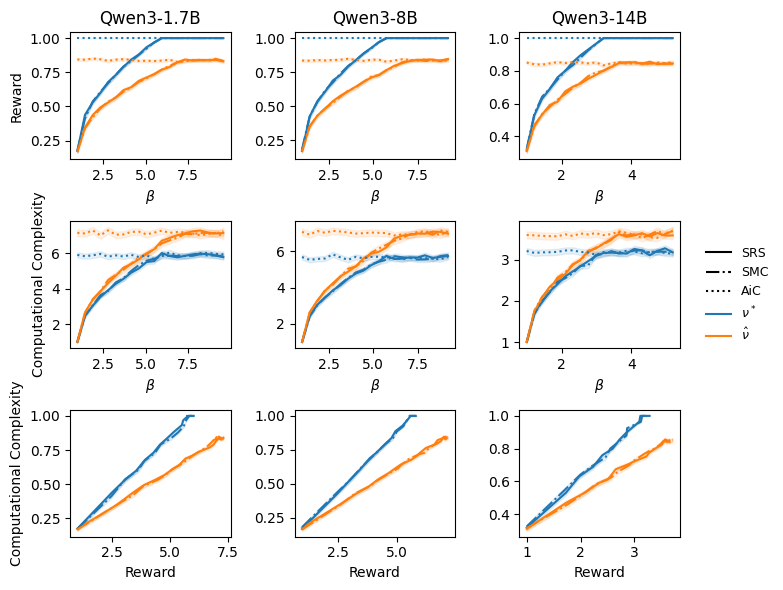

In [25]:
methods = df["method"].unique()
modes = df["mode"].unique()

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(3, len(model_ids), figsize=(7, 6), sharey=False)
for ax,model_id in zip(axs[0], model_ids):
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

            ax.plot(plot_df["beta"], plot_df["reward"], label=method, linestyle=linestyles[method], color=colors[mode])
            ax.set_title(model_id.split("/")[-1])

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["reward"] - 1.96*plot_df["reward_std"]/np.sqrt(5000),
                plot_df["reward"] + 1.96*plot_df["reward_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )
    
    ax.set_xlabel(r"$\beta$")

axs[0][0].set_ylabel("Reward")
#axs[0][-2].legend(ncols=2)

for ax,model_id in zip(axs[1], model_ids):
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

            shat = plot_df["s"].iloc[0]
            #ax.axhline(1/shat, color=colors[mode])
            ax.plot(plot_df["beta"], plot_df["iter"], label=method, linestyle=linestyles[method], color=colors[mode])
            

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["iter"] - 1.96*plot_df["iter_std"]/np.sqrt(5000),
                plot_df["iter"] + 1.96*plot_df["iter_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )

    ax.set_xlabel(r"$\beta$")
axs[1][0].set_ylabel("Computational Complexity")
#axs[1][-2].legend(ncols=2)

for ax,model_id in zip(axs[2], model_ids):
    for method in methods:
        for mode in modes:
        
            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]
            
            idx = plot_df["iter"].argsort()
            iters_sorted = plot_df["iter"].iloc[idx]
            rewards_sorted = plot_df["reward"].iloc[idx]
            ax.plot(iters_sorted, rewards_sorted, label=method, linestyle=linestyles[method], color=colors[mode])
            #ax.set_title(model_id)

            stds = plot_df["reward_std"].iloc[idx]
            # Add shaded area for standard deviation
            ax.fill_between(
                iters_sorted,
                rewards_sorted - 1.96*stds/np.sqrt(5000),
                rewards_sorted + 1.96*stds/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )
    
    ax.set_xlabel(r"Reward")
axs[2][0].set_ylabel("Computational Complexity")
#axs[2][-2].legend(ncols=2)


# Manual legend entries for methods (line styles)
method_handles = [
    Line2D([0], [0], color="black", linestyle=linestyles[method], label=method)
    for method in methods
]

# Manual legend entries for modes (colors)
labels = {
    "ground_truth": r"$\nu^*$",
    "estimate": r"$\hat{\nu}$"
}
mode_handles = [
    Line2D([0], [0], color=colors[mode], linestyle="-", label=labels[mode])
    for mode in modes
]

# Combine both legends
all_handles = method_handles + mode_handles
all_labels = [h.get_label() for h in all_handles]

# Place legend to the right of the figure
fig.legend(
    handles=all_handles,
    labels=all_labels,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),  # adjust x/y position
    frameon=False,
    fontsize=9,
    title="",
)


plt.tight_layout()

plt.savefig(
    f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/reward_complexity.pdf",
    dpi=800, 
    bbox_inches="tight",
    #bbox_extra_artists=(legend1, legend2)
)
plt.show()




## Sub-optimality

In [26]:
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1736,0.378765,1.0000,0.000000,SRS,ground_truth,0.662615
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1724,0.377728,1.0000,0.000000,SMC,ground_truth,0.662615
2,1.000000,Qwen/Qwen3-1.7B,0.170036,1.0000,0.000000,5.9024,5.340644,AiC,ground_truth,0.662615
3,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1730,0.378247,1.0000,0.000000,SRS,estimate,0.662615
4,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1678,0.373689,1.0000,0.000000,SMC,estimate,0.662615
...,...,...,...,...,...,...,...,...,...,...
355,5.182043,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.1968,2.641604,SMC,ground_truth,0.685710
356,5.182043,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.1512,2.649064,AiC,ground_truth,0.685710
357,5.182043,Qwen/Qwen3-14B,0.276199,0.8446,0.362286,3.5934,3.054583,SRS,estimate,0.685710
358,5.182043,Qwen/Qwen3-14B,0.276199,0.8436,0.363234,3.7038,3.251840,SMC,estimate,0.685710


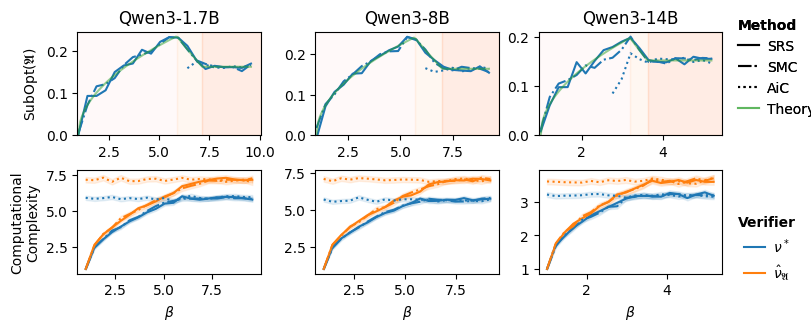

In [5]:

methods = df["method"].unique()
#methods = ["AiC"]

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(2, len(model_ids), figsize=(8, 3.2), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip(axs[0], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["J"].iloc[0]
    )

    for method in methods:   
        if method=="AiC":
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]=="SRS")
            ]
        else:
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

        estimated_df = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

        suboptimality = gt_df["reward"].values - estimated_df["reward"].values

        if method=="AiC":
            mask = gt_df["beta"] >= (1/shat - 1)
            ax.plot(gt_df.loc[mask, "beta"], suboptimality[mask], label=method, linestyle=linestyles[method], color="tab:blue")
        else:
            ax.plot(gt_df["beta"], suboptimality, label=method, linestyle=linestyles[method], color="tab:blue")
        ax.set_title(model_id.split("/")[-1])

        idx = estimated_df["iter"].argsort()
        iters_sorted = estimated_df["iter"].iloc[idx]
        suboptimality_sorted = suboptimality[idx]

    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)


    ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:green", alpha=0.5)    
    #ax.set_xlabel(r"$\beta$")
    ax.set_ylim(0)
    #ax.axvline(1/shat-1)
    #ax.grid(linestyle="--", alpha=0.3)


axs[0][0].set_ylabel(r"${\rm SubOpt}(\mathfrak{A})$")
#axs[0][-2].legend(ncols=2)

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

# Add theory handle (green dashed line like in your plot)
theory_handle = Line2D([0], [0], color="tab:green", linestyle="-", alpha=0.5, label="Theory")

# Combine methods + theory
method_handles_with_theory = method_handles + [theory_handle]

# Place two legends: one for methods, one for modes
legend1 = axs[0][-1].legend(
    handles=method_handles_with_theory, 
    title="Method", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
axs[0][-1].add_artist(legend1)  # keep the first legend when adding the second

legend1._legend_box.align = "left"

#######################################################################################################################################

for ax, model_id in zip(axs[1], model_ids):
    for method in methods:
        for mode in modes:

            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"] == method)
            ]

            shat = plot_df["s"].iloc[0]

            # Plot mean line
            ax.plot(
                plot_df["beta"],
                plot_df["iter"],
                label=method,
                linestyle=linestyles[method],
                color=colors[mode]
            )

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["iter"] - 1.96*plot_df["iter_std"]/np.sqrt(5000),
                plot_df["iter"] + 1.96*plot_df["iter_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )

    ax.set_xlabel(r"$\beta$")
    
axs[1][0].set_ylabel("Computational\nComplexity")

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

mode_titles = [r"$\nu^*$", r"$\hat{\nu}_{\mathfrak{A}}$"]
mode_handles = [
    Line2D([0], [0], color=clr, linestyle="-", label=mode_titles[i])
    for i, (mode, clr) in enumerate(colors.items())
]

# Place two legends: one for methods, one for modes
legend1 = axs[1][-1].legend(
    handles=method_handles + mode_handles, 
    title="",#r"Algorithm $\mathfrak{A}$", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
#axs[1][-1].add_artist(legend1)  # keep the first legend when adding the second
legend1._legend_box.align = "left"

legend2 = axs[1][-1].legend(
    handles=mode_handles, 
    ncols=1,
    title="Verifier",
    loc="lower left", 
    bbox_to_anchor=(1.02, -0.2), 
    frameon=False,
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
# legend2._legend_box.align = "left"

#plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig1.pdf",
    dpi=800, 
    bbox_inches="tight",
    bbox_extra_artists=(legend1, legend2)
)
plt.show()




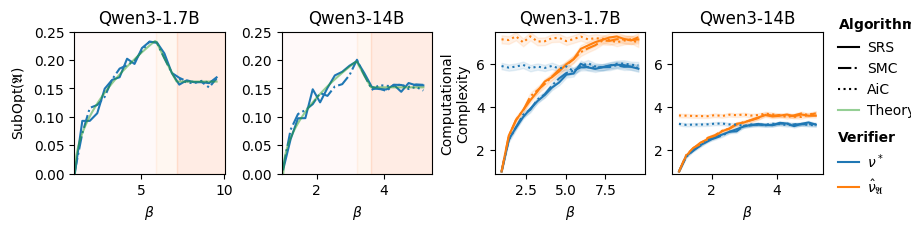

In [12]:
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-14B"]


methods = df["method"].unique()
#methods = ["AiC"]

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(1, len(model_ids)*2, figsize=(9, 2.2), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip(axs[:2], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["J"].iloc[0]
    )

    for method in methods:   
        if method=="AiC":
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]=="SRS")
            ]
        else:
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method)
            ]

        estimated_df = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

        suboptimality = gt_df["reward"].values - estimated_df["reward"].values

        if method=="AiC":
            mask = gt_df["beta"] >= (1/shat)
            ax.plot(gt_df.loc[mask, "beta"], suboptimality[mask], label=method, linestyle=linestyles[method], color="tab:blue")
        else:
            ax.plot(gt_df["beta"], suboptimality, label=method, linestyle=linestyles[method], color="tab:blue")
        ax.set_title(model_id.split("/")[-1])

        idx = estimated_df["iter"].argsort()
        iters_sorted = estimated_df["iter"].iloc[idx]
        suboptimality_sorted = suboptimality[idx]

    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)


    ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:green", alpha=0.5)    
    ax.set_xlabel(r"$\beta$")
    ax.set_ylim(0,0.25)
    #ax.axvline(1/shat-1)
    #ax.grid(linestyle="--", alpha=0.3)


axs[0].set_ylabel(r"${\rm SubOpt}(\mathfrak{A})$")
#axs[0][-2].legend(ncols=2)

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

# Add theory handle (green dashed line like in your plot)
theory_handle = Line2D([0], [0], color="tab:green", linestyle="-", alpha=0.5, label="Theory")

# Combine methods + theory
method_handles_with_theory = method_handles + [theory_handle]

# Place two legends: one for methods, one for modes
legend1 = axs[-1].legend(
    handles=method_handles_with_theory, 
    title="Method", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.25), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
#axs[-1].add_artist(legend1)  # keep the first legend when adding the second

legend1._legend_box.align = "left"

ax.set_xlabel(r"$\beta$")

#######################################################################################################################################

for ax, model_id in zip(axs[2:], model_ids):
    for method in methods:
        for mode in modes:

            plot_df = df[
                (df["mode"] == mode) &
                (df["model_id"] == model_id) &
                (df["method"] == method)
            ]

            shat = plot_df["s"].iloc[0]

            # Plot mean line
            ax.plot(
                plot_df["beta"],
                plot_df["iter"],
                label=method,
                linestyle=linestyles[method],
                color=colors[mode]
            )

            # Add shaded area for standard deviation
            ax.fill_between(
                plot_df["beta"],
                plot_df["iter"] - 1.96*plot_df["iter_std"]/np.sqrt(5000),
                plot_df["iter"] + 1.96*plot_df["iter_std"]/np.sqrt(5000),
                color=colors[mode],
                alpha=0.1
            )

    ax.set_xlabel(r"$\beta$")
    ax.set_title(model_id.split("/")[-1])
    ax.set_ylim(0.9, 7.5)
    
axs[2].set_ylabel("Computational\nComplexity")

# Build manual legend
method_handles = [
    Line2D([0], [0], color="black", linestyle=ls, label=method)
    for i, (method, ls) in enumerate(linestyles.items())
]

mode_titles = [r"$\nu^*$", r"$\hat{\nu}_{\mathfrak{A}}$"]
mode_handles = [
    Line2D([0], [0], color=clr, linestyle="-", label=mode_titles[i])
    for i, (mode, clr) in enumerate(colors.items())
]

# Place two legends: one for methods, one for modes
legend1 = axs[-1].legend(
    handles=method_handles_with_theory,# + mode_handles, 
    title=r"Algorithm $\mathfrak{A}$", 
    ncols=1,
    loc="upper left", 
    bbox_to_anchor=(1.02, 1.2), 
    frameon=False, 
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
axs[-1].add_artist(legend1)  # keep the first legend when adding the second
legend1._legend_box.align = "left"

legend2 = axs[-1].legend(
    handles=mode_handles, 
    ncols=1,
    title="Verifier",
    loc="lower left", 
    bbox_to_anchor=(1.02, -0.25), 
    frameon=False,
    handlelength=1.5, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)
legend2._legend_box.align = "left"

#plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig1.pdf",
    dpi=800, 
    bbox_inches="tight",
    bbox_extra_artists=(legend1, legend2)
)
plt.show()




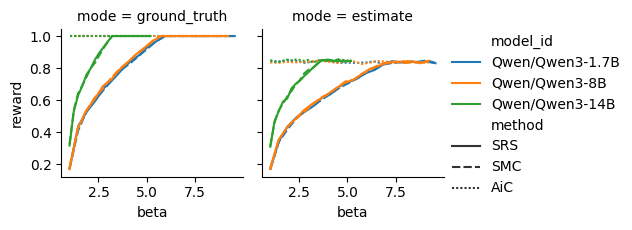

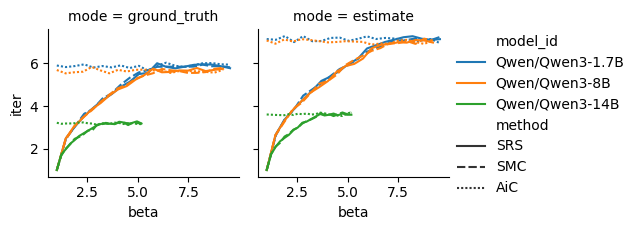

In [7]:
sns.relplot(
    data=df, 
    x="beta", 
    y="reward",
    hue="model_id",
    style="method",
    col="mode",
    kind="line",
    height=2.4
)

sns.relplot(
    data=df, 
    x="beta", 
    y="iter",
    hue="model_id",
    style="method",
    col="mode",
    kind="line",
    height=2.4
)

## Ablation - Varying $J$

In [4]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_J/{task}-{model_name}-episodes{num_episodes}-i{sample_id}.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
0,1.176222,Qwen/Qwen3-1.7B,0.170036,0.3298,0.470140,1.9100,1.331878,SRS,ground_truth,-0.164816
1,1.176222,Qwen/Qwen3-1.7B,0.170036,0.3150,0.464516,1.8870,2.943642,SMC,ground_truth,-0.164816
2,1.176222,Qwen/Qwen3-1.7B,0.170036,1.0000,0.000000,5.8468,5.242340,AiC,ground_truth,-0.164816
3,1.176222,Qwen/Qwen3-1.7B,0.136791,0.1412,0.348228,2.0718,1.515732,SRS,estimate,-0.164816
4,1.176222,Qwen/Qwen3-1.7B,0.136791,0.1516,0.358633,2.0920,3.738387,SMC,estimate,-0.164816
...,...,...,...,...,...,...,...,...,...,...
535,3.826740,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.1620,2.577859,SMC,ground_truth,0.873441
536,3.826740,Qwen/Qwen3-14B,0.313583,1.0000,0.000000,3.2026,2.619915,AiC,ground_truth,0.873441
537,3.826740,Qwen/Qwen3-14B,0.273896,1.0000,0.000000,3.6162,3.065893,SRS,estimate,0.873441
538,3.826740,Qwen/Qwen3-14B,0.273896,1.0000,0.000000,3.6628,3.077969,SMC,estimate,0.873441


In [5]:
df[
    (df["model_id"]=="Qwen/Qwen3-1.7B") &
    (df["method"]=="SRS") &
    (df["mode"]=="estimate")
]

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J
3,1.176222,Qwen/Qwen3-1.7B,0.136791,0.1412,0.348228,2.0718,1.515732,SRS,estimate,-0.164816
9,6.616251,Qwen/Qwen3-1.7B,0.136791,0.0102,0.100479,7.0286,6.621283,SRS,estimate,-0.164816
15,8.821668,Qwen/Qwen3-1.7B,0.136791,0.0000,0.000000,7.2220,6.739282,SRS,estimate,-0.164816
21,1.176222,Qwen/Qwen3-1.7B,0.136830,0.1608,0.367346,2.0502,1.443634,SRS,estimate,-0.056776
27,6.616251,Qwen/Qwen3-1.7B,0.136830,0.1158,0.319985,6.8644,6.394561,SRS,estimate,-0.056776
33,8.821668,Qwen/Qwen3-1.7B,0.136830,0.1150,0.319022,7.3588,6.743535,SRS,estimate,-0.056776
39,1.176222,Qwen/Qwen3-1.7B,0.137170,0.1734,0.378593,2.0542,1.458925,SRS,estimate,0.051579
45,6.616251,Qwen/Qwen3-1.7B,0.137170,0.2156,0.411238,6.9080,6.409238,SRS,estimate,0.051579
51,8.821668,Qwen/Qwen3-1.7B,0.137170,0.2250,0.417582,7.3306,6.880851,SRS,estimate,0.051579
57,1.176222,Qwen/Qwen3-1.7B,0.137799,0.2012,0.400897,2.0580,1.504339,SRS,estimate,0.159073


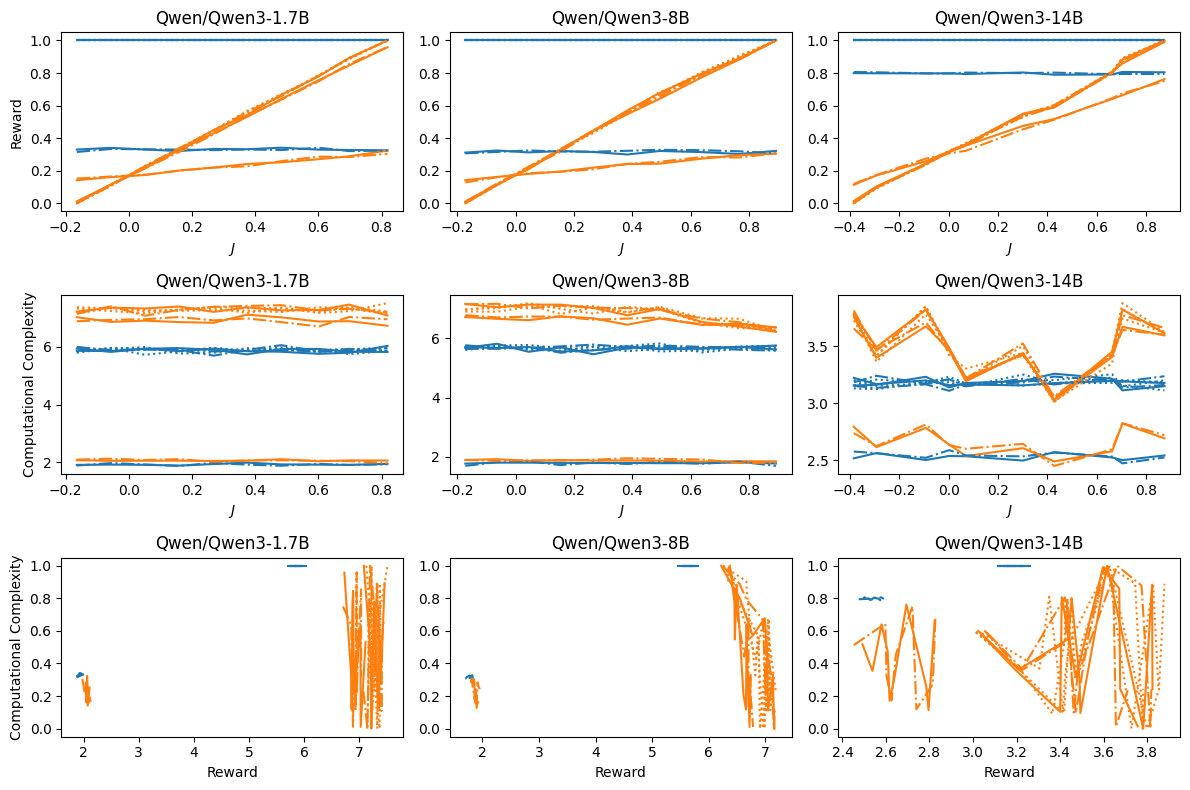

In [6]:
methods = df["method"].unique()
modes = df["mode"].unique()

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

fig, axs = plt.subplots(3, len(model_ids), figsize=(12, 8), sharey=False)
for ax,model_id in zip(axs[0], model_ids):
    for method in methods:
        for mode in modes:
            betas = df[df["model_id"] == model_id]["beta"].unique()
            for beta in betas:
                plot_df = df[
                    (df["mode"] == mode) &
                    (df["model_id"] == model_id) &
                    (df["method"]==method) &
                    (df["beta"]==beta)
                ]

                ax.plot(plot_df["J"], plot_df["reward"], label=f"{method}-{beta}", linestyle=linestyles[method], color=colors[mode])
                ax.set_title(model_id)
    
    ax.set_xlabel(r"$J$")

axs[0][0].set_ylabel("Reward")
#axs[0][-2].legend(ncols=2)

for ax,model_id in zip(axs[1], model_ids):
    for method in methods:
        for mode in modes:
        
            betas = df[df["model_id"] == model_id]["beta"].unique()
            for beta in betas:
                plot_df = df[
                    (df["mode"] == mode) &
                    (df["model_id"] == model_id) &
                    (df["method"]==method) &
                    (df["beta"]==beta)
                ]

                ax.plot(plot_df["J"], plot_df["iter"], label=method, linestyle=linestyles[method], color=colors[mode])
                ax.set_title(model_id)

    ax.set_xlabel(r"$J$")
axs[1][0].set_ylabel("Computational Complexity")
#axs[1][-2].legend(ncols=2)

for ax,model_id in zip(axs[2], model_ids):
    for method in methods:
        for mode in modes:
        
            betas = df[df["model_id"] == model_id]["beta"].unique()
            for beta in betas:
                plot_df = df[
                    (df["mode"] == mode) &
                    (df["model_id"] == model_id) &
                    (df["method"]==method) &
                    (df["beta"]==beta)
                ]
            
                idx = plot_df["iter"].argsort()
                iters_sorted = plot_df["iter"].iloc[idx]
                rewards_sorted = plot_df["reward"].iloc[idx]
                ax.plot(iters_sorted, rewards_sorted, label=method, linestyle=linestyles[method], color=colors[mode])
                ax.set_title(model_id)
    
    ax.set_xlabel(r"Reward")
axs[2][0].set_ylabel("Computational Complexity")
#axs[2][-2].legend(ncols=2)


plt.tight_layout()
plt.show()




### Sub-optimality

[1.17622237 6.61625083 8.82166777]
[1.17622237 6.61625083 8.82166777]
[1.17622237 6.61625083 8.82166777]
[1.13386261 6.37797718 8.50396957]
[1.13386261 6.37797718 8.50396957]
[1.13386261 6.37797718 8.50396957]
[2.09447479 3.58756828 3.8267395 ]
[2.09447479 3.58756828 3.8267395 ]
[2.09447479 3.58756828 3.8267395 ]


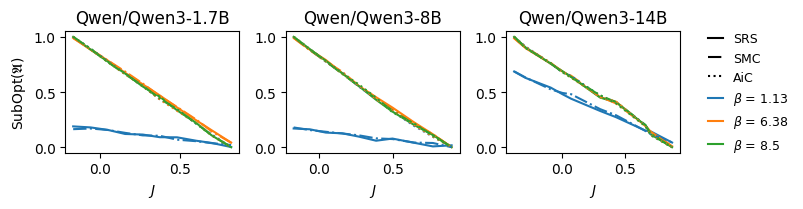

In [22]:
methods = df["method"].unique()
#methods = ["AiC"]

linestyles={
    "SRS": "-",
    "SMC": "-.",
    "AiC": ":"
}

colors=["tab:blue", "tab:orange", "tab:green"]

fig, axs = plt.subplots(1, len(model_ids), figsize=(7, 2.2), sharey=False, sharex=False)

for ax,model_id in zip(axs, model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id)
        ]["s"].iloc[0]
    )

    for method in methods: 
        betas = df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]==method)
        ]["beta"].unique()
        print(betas)
        
        for b,beta in enumerate(betas):      
            gt_df = df[
                (df["mode"] == "ground_truth") &
                (df["model_id"] == model_id) &
                (df["method"]==method) &
                (df["beta"]==beta)
            ]

            estimated_df = df[
                (df["mode"] == "estimate") &
                (df["model_id"] == model_id) &
                (df["method"]==method) & 
                (df["beta"]==beta)
            ]

            # subopt_theory_fn = get_subopt_theory_fn(s, shat, J)
            # subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

            suboptimality = gt_df["reward"].values - estimated_df["reward"].values

            ax.plot(gt_df["J"], suboptimality, label=f"{method}-{beta:.2f}", linestyle=linestyles[method], color=colors[b])
            ax.set_title(model_id)

            idx = estimated_df["iter"].argsort()
            iters_sorted = estimated_df["iter"].iloc[idx]
            suboptimality_sorted = suboptimality[idx]

    
    #ax.plot(betas, subopt_theory, label="theory", linestyle="-", color="tab:orange")    
    ax.set_xlabel(r"$J$")

axs[0].set_ylabel(r"SubOpt($\mathfrak{A}$)")

#######################################################################################################################################
from matplotlib.lines import Line2D

# Define beta values and method names (ensure correct order)
beta_values = [1.13, 6.38, 8.5]
method_names = ["SRS", "SMC", "AiC"]

# Handles for methods (linestyles)
method_handles = [
    Line2D([0], [0], color="black", linestyle=linestyles[m], label=m)
    for m in method_names
]

# Handles for betas (colors, solid line)
beta_handles = [
    Line2D([0], [0], color=colors[i], linestyle="-", label=r"$\beta$ = {}".format(b))
    for i, b in enumerate(beta_values)
]

# Combine and place custom legend
all_handles = method_handles + beta_handles
all_labels = [h.get_label() for h in all_handles]

fig.legend(
    handles=all_handles,
    labels=all_labels,
    loc="center right",
    bbox_to_anchor=(1.15, 0.55),
    frameon=False,
    title="",
    handlelength=1.25,
    fontsize=9
)

plt.tight_layout()
# Save in pdf format
plt.savefig(
    f"/home/mb1921/ot-resampling/tasks/gsm8k/results-{sample_id}/plots/suboptimality_vs_J.pdf",
    dpi=800, 
    bbox_inches="tight",
)
plt.show()


## Batched

In [17]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path1 = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-batched.csv"
    model_df1 = pd.read_csv(data_path1)
    model_dfs.append(model_df1)
    print(model_df1["beta"].unique())

    data_path2 = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN.csv"
    model_df2 = pd.read_csv(data_path2)
    model_dfs.append(model_df2)
    print(model_df2["beta"].unique())

# for model_id in model_ids: 
#     model_name = model_id.replace("/", "__")
#     data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN-beta1.csv"
#     model_df = pd.read_csv(data_path)
#     model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)
df

[1.         1.45035825 1.9007165  2.35107475 2.801433   3.25179125
 3.7021495  4.15250775 4.602866   5.05322425 5.5035825  5.95394075
 6.404299   6.85465725 7.3050155  7.75537375 8.205732   8.65609025
 9.1064485  9.55680675]
[1.         1.45035825 1.9007165  2.35107475 2.801433   3.25179125
 3.7021495  4.15250775 4.602866   5.05322425 5.5035825  5.95394075
 6.404299   6.85465725 7.3050155  7.75537375 8.205732   8.65609025
 9.1064485  9.55680675]
[1.         1.43224388 1.86448776 2.29673164 2.72897552 3.1612194
 3.59346328 4.02570715 4.45795103 4.89019491 5.32243879 5.75468267
 6.18692655 6.61917043 7.05141431 7.48365819 7.91590207 8.34814595
 8.78038983 9.21263371]
[1.         1.43224388 1.86448776 2.29673164 2.72897552 3.1612194
 3.59346328 4.02570715 4.45795103 4.89019491 5.32243879 5.75468267
 6.18692655 6.61917043 7.05141431 7.48365819 7.91590207 8.34814595
 8.78038983 9.21263371]
[1.         1.22010753 1.44021506 1.66032259 1.88043012 2.10053765
 2.32064518 2.54075271 2.76086024 2

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1710,0.376509,1.0,0.0,BRS,ground_truth,0.662615,1
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1772,0.381838,1.0,0.0,BRS,ground_truth,0.662615,2
2,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1748,0.379796,1.0,0.0,BRS,ground_truth,0.662615,3
3,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1642,0.370457,1.0,0.0,BRS,ground_truth,0.662615,4
4,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1832,0.386830,1.0,0.0,BRS,ground_truth,0.662615,6
...,...,...,...,...,...,...,...,...,...,...,...
1097,5.182043,Qwen/Qwen3-14B,0.313583,0.8528,0.354305,5.0,0.0,BoN,ground_truth,0.685710,4
1098,5.182043,Qwen/Qwen3-14B,0.276199,0.4640,0.498702,2.0,0.0,BoN,estimate,0.685710,1
1099,5.182043,Qwen/Qwen3-14B,0.276199,0.5730,0.494642,3.0,0.0,BoN,estimate,0.685710,2
1100,5.182043,Qwen/Qwen3-14B,0.276199,0.6480,0.477594,4.0,0.0,BoN,estimate,0.685710,3


In [18]:
# model_name = "Qwen/Qwen3-1.7B".replace("/", "__")
# data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN.csv"
# model_df = pd.read_csv(data_path)
# model_df

In [19]:
# model_name = "Qwen/Qwen3-1.7B".replace("/", "__")
# data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-batched.csv"
# model_df = pd.read_csv(data_path)
# print(model_df["beta"].unique())
# model_df

In [20]:
# import sys, os
# ROOT = os.path.abspath("/home/mb1921/ot-resampling/")
# sys.path.insert(0, ROOT)

# import argparse
# import numpy as np
# import pandas as pd
# from tqdm.auto import tqdm, trange
# from sampling_utils import get_df, get_estimated_df, get_youden_bounds, compute_s, get_membership_fn, batched_rejection_sampling

# def parse_args():
#     parser = argparse.ArgumentParser(description="Train Pluralistic Reward Model with configurable parameters.")
#     parser.add_argument("--user_id", type=str, required=True)
#     parser.add_argument("--models", type=str, nargs="+", required=True, help="List of model names to show")
#     parser.add_argument("--task", type=str, required=True)
#     parser.add_argument("--i", type=int, required=True)
#     parser.add_argument("--seed", type=int, required=True)
#     parser.add_argument("--num_beta_points", type=int, default=20)
#     parser.add_argument("--num_episodes", type=int, default=1e2)
#     return parser.parse_args()

# def compute_shat_heuristic(s, fraction):
#     return fraction*s

# def compute_J_heuristic(s_list, shat_list, fraction):
#     upJs = []
#     for s, shat in zip(s_list, shat_list):
#         _, upJ = get_youden_bounds(s, shat)
#         upJs.append(upJ)  
#     J = min(upJs)
#     return fraction*J

# def get_compute_reward(true_df):
#     check_true_memebership = get_membership_fn(true_df, "exact_match")
#     def compute_reward(sample_id):
#         return check_true_memebership(sample_id).astype(int)
#     return compute_reward



# if __name__ == "__main__":

#     # Arguments
#     user_id = "marcellobullo"
#     model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
#     task = "gsm8k"
#     sample_id = 2
#     seed = 14
#     batch_sizes=np.linspace(1,10,10, dtype=int)
#     num_beta_points = 20
#     num_episodes = 200
#     model_dfs = []

#     fraction = 0.8

#     # Compute a J feasible for all the models
#     s_list, shat_list, true_dfs = [], [], []
#     for model_id in model_ids:
        
#         # Get the full dataset
#         true_df = get_df(user_id, task, model_id.replace("/", "__"), sample_id)
#         true_dfs.append(true_df)

#         # Compute s and shat
#         s = compute_s(true_df, "exact_match")
#         print("S:", s)
#         s_list.append(s)

#         shat = compute_shat_heuristic(s, fraction)
#         shat_list.append(shat)
#     J = compute_J_heuristic(s_list, shat_list, fraction)

#     # Compute shared betas
#     mins = min(s_list)
#     minshat = min(shat_list)
#     betas = np.linspace(1.0, max(1/minshat, 1/mins)*1.3, num_beta_points)

#     # Paramters
#     rng = np.random.default_rng(seed)
#     result_list = []

#     for i, (model_id, s, shat, true_df) in enumerate(zip(model_ids, s_list, shat_list, true_dfs)):

#         # True df
#         check_true_memebership = get_membership_fn(true_df, "exact_match")
#         compute_reward = get_compute_reward(true_df)

#         # Construct Shat set (estimated_df)
#         estimated_shat, estimated_J, estimated_df = get_estimated_df(J, shat, user_id, task, model_id.replace("/", "__"), sample_id)

#         # Dataframes
#         dfs = {
#             "ground_truth": true_df,
#             "estimate": estimated_df
#         }

#         ss = {
#             "ground_truth": s,
#             "estimate": estimated_shat    
#         }

#         # Compute
#         for beta in tqdm(betas, desc=f"{model_id} - J: {J} - shat {shat}"):

#             for mode, df in dfs.items():
                
#                 # Batched Rejection sampling
#                 for batch_size in batch_sizes:
#                     rewards, iters = [], []
#                     for t in trange(num_episodes, desc="SRS", leave=False):
#                         res = batched_rejection_sampling(df, beta, ss[mode], batch_size=batch_size, rng=rng)
#                         reward = compute_reward(res["sample_id"])
#                         rewards.append(reward)
#                         iters.append(res["iter"])
#                     results = {
#                         "beta": beta,
#                         "model_id": model_id,
#                         "s": ss[mode],
#                         "reward": np.mean(rewards),
#                         "reward_std": np.std(rewards),
#                         "iter": np.mean(iters),
#                         "iter_std": np.std(iters),
#                         "method": "BRS",
#                         "mode": mode,
#                         "J": estimated_J,
#                         "N": batch_size
#                     }
#                     result_list.append(results)

#     # fig, axes = plt.subplots(1,2, figsize=(4,8))
#     result_df = pd.DataFrame(result_list)

#     model_names_flat = ""
#     for model_id in model_ids: model_names_flat += model_id.replace("/", "__")

#     new_dir = os.path.join(ROOT, f"tasks/{task}/results-{sample_id}/suboptimality_vs_beta")
#     os.makedirs(new_dir, exist_ok=True)
#     result_df_path = os.path.join(new_dir, f"{task}-{model_names_flat}-episodes{num_episodes}-i{sample_id}-batched.csv")
#     #result_df.to_csv(result_df_path, index=False)

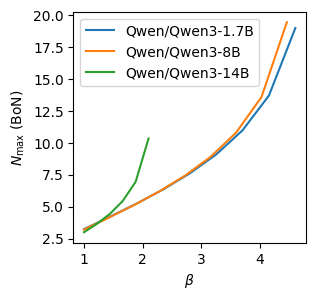

In [21]:
def compute_max_batch_size(beta, s):
    if beta >= (1-s)/s:
        return np.infty
    elif s*(1-s) <= beta <= (1-s)/s:
        return np.log(1-np.sqrt((beta*s)/(1-s)))/np.log(1-s)
    else:
        raise("Undetermined")

plt.figure(figsize=(3,3))
for model_id in model_ids:
    res_df = df[
        (df["model_id"]==model_id) &
        (df["mode"]=="ground_truth")
    ]
    betas = res_df["beta"].unique()
    s = res_df["s"].iloc[0]

    max_batch_sizes = []
    for beta in betas:
        max_batch_sizes.append(compute_max_batch_size(beta, s))

    
    plt.plot(betas, max_batch_sizes, label=model_id)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$N_{\rm max}$ (BoN)")
plt.legend()
plt.show()

/tmp/ipykernel_2926498/278288977.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r", len(Ns))


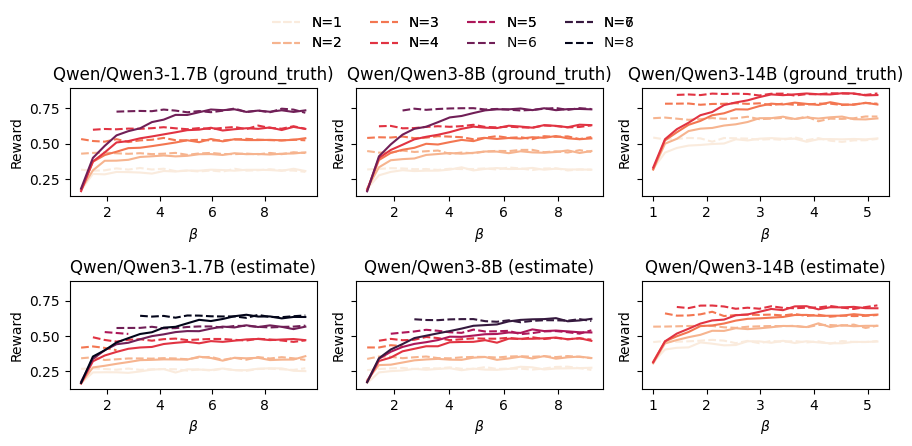

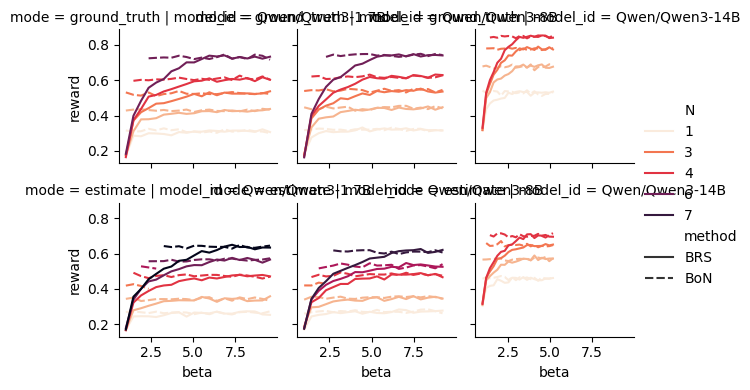

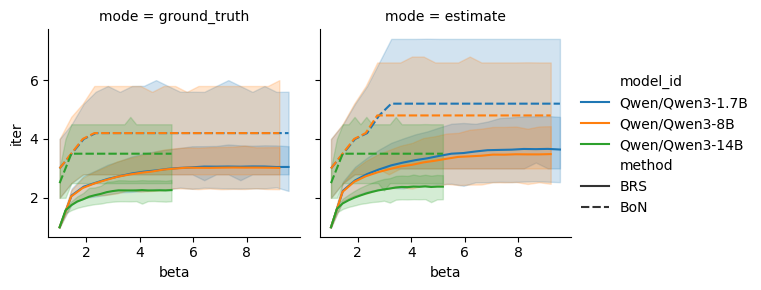

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Unique facets
modes = df["mode"].unique()
models = df["model_id"].unique()
methods = df["method"].unique()
Ns = sorted(df["N"].unique())

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}

# Marker/linestyle map for methods
styles = ["-", "--", "-.", ":"]
style_map = {m: styles[i % len(styles)] for i, m in enumerate(methods)}

fig, axes = plt.subplots(len(modes), len(models),
                         figsize=(len(models)*3, len(modes)*2),
                         sharex=False, sharey=True)

if len(modes) == 1 and len(models) == 1:
    axes = np.array([[axes]])
elif len(modes) == 1:
    axes = axes[np.newaxis, :]
elif len(models) == 1:
    axes = axes[:, np.newaxis]

for i, mode in enumerate(modes):
    for j, model in enumerate(models):
        ax = axes[i, j]
        df_sub = df[(df["mode"] == mode) &
                           (df["model_id"] == model)]
        # Loop over groups
        for (n_val, method), df_group in df_sub.groupby(["N", "method"]):
            ax.plot(df_group["beta"], df_group["reward"],
                    linestyle=style_map[method],
                    color=color_map[n_val],
                    label=f"N={n_val}")
        
        ax.set_title(f"{model} ({mode})")
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel("Reward")
        #ax.legend(fontsize=8)

    # After plotting everything:
    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Deduplicate
    unique = dict(zip(labels, handles))

    # Place a single legend on top
    fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.5, 1.12),
            loc="upper center", ncol=4, frameon=False)

plt.tight_layout()
plt.show()

sns.relplot(
    data=df, 
    x="beta", 
    y="reward",
    hue="N",
    style="method",
    col="model_id",
    kind="line",
    height=2,
    row="mode",
    palette="rocket_r"
)

sns.relplot(
    data=df, 
    x="beta", 
    y="iter",
    hue="model_id",
    style="method",
    col="mode",
    kind="line",
    height=3
)

### Sub-optimality

In [28]:
def get_subopt_theory_fn_batch(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        M = min(1/s, m/s) 
        return otc(beta, s)*((1-1/M)**N)
    return subopt_theory_fn

def get_subopt_theory_fn_batch_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m_star = s + np.sqrt(s*(1-s)*(beta-1))
        m_shat = shat + np.sqrt(shat*(1-shat)*(beta-1))
        M = min(1/shat, m_shat/shat) 
        alpha = 1 - (1-1/M)**N
        OTC = otc(beta, s)
        TPR = shat + (1 - s) * J
        
        # Transport regime
        if beta <= min(1/s, 1/shat):
            term = m_star/s - ( (m_shat*TPR)/(shat) + ((1-m_shat)*(1-TPR))/(1-shat) )
            suboptimality = (1-alpha)*OTC + alpha*s*term #( m_star/s - ( (m_shat*TPR)/shat + ((1-m_shat)*(1-TPR))/(1-shat)))

        # Policy Improvement regime
        elif min(1/shat, 1/s) < beta <= max(1/shat, 1/s):
            if shat > s:
                term = m_star/s - TPR/shat
            else:
                term = 1/s - ((m_shat*TPR)/shat + (((1-m_shat)*(1-TPR))/(1-shat)) )
            suboptimality = (1-alpha)*OTC + alpha*s*term
        
        # Saturation regime
        else: #beta > max(1/shat, 1/s):
            suboptimality = (1-alpha)*OTC + alpha*s*(1/s - TPR/shat)
        
        return suboptimality
    return subopt_theory_fn

def get_subopt_theory_fn_BoN(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        return (1-s)**(N+1) - max(0, 1-m)
    return subopt_theory_fn

def get_subopt_theory_fn_BoN_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        sampling_error = ((1-shat)**(N+1))*(s/shat)*J - max(0, 1-m)
        verification_error = (1-s)*(1-(s*J)/shat)
        return sampling_error + verification_error        
    return subopt_theory_fn

In [29]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
#model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B"]

task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df_sequential = pd.concat(model_dfs, ignore_index=True)
# Ensure both have the same columns
if "N" not in df.columns: df["N"] = np.nan   # or a default value (e.g., 1)


model_dfs_batched = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-batched.csv"
    model_df = pd.read_csv(data_path)
    model_dfs_batched.append(model_df)

for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN.csv"
    model_df = pd.read_csv(data_path)
    model_dfs_batched.append(model_df)

for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN-beta1.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df_batched = pd.concat(model_dfs_batched, ignore_index=True)


# Concatenate
df = pd.concat([df_sequential, df_batched], ignore_index=True)
df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1736,0.378765,1.0000,0.000000,SRS,ground_truth,0.662615,NaN
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.1724,0.377728,1.0000,0.000000,SMC,ground_truth,0.662615,NaN
2,1.000000,Qwen/Qwen3-1.7B,0.170036,1.0000,0.000000,5.9024,5.340644,AiC,ground_truth,0.662615,NaN
3,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1730,0.378247,1.0000,0.000000,SRS,estimate,0.662615,NaN
4,1.000000,Qwen/Qwen3-1.7B,0.140030,0.1678,0.373689,1.0000,0.000000,SMC,estimate,0.662615,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1457,5.182043,Qwen/Qwen3-14B,0.313583,0.8528,0.354305,5.0000,0.000000,BoN,ground_truth,0.685710,4.0
1458,5.182043,Qwen/Qwen3-14B,0.276199,0.4640,0.498702,2.0000,0.000000,BoN,estimate,0.685710,1.0
1459,5.182043,Qwen/Qwen3-14B,0.276199,0.5730,0.494642,3.0000,0.000000,BoN,estimate,0.685710,2.0
1460,5.182043,Qwen/Qwen3-14B,0.276199,0.6480,0.477594,4.0000,0.000000,BoN,estimate,0.685710,3.0


In [78]:
bon_df = model_dfs_batched[-3]
bon_df[
    (bon_df["mode"]=="estimate") &
    (bon_df["N"]==5) 
].reset_index()

,index,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,23,1.900716,Qwen/Qwen3-1.7B,0.14003,0.5278,0.499227,6.0,0.0,BoN,estimate,0.662615,5
1,42,2.801433,Qwen/Qwen3-1.7B,0.14003,0.5148,0.499781,6.0,0.0,BoN,estimate,0.662615,5


In [79]:
bon_df = model_dfs_batched[-3]
bon_df[
    (bon_df["mode"]=="estimate") &
    (bon_df["N"]==5) 
].reset_index()

,index,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,23,1.900716,Qwen/Qwen3-1.7B,0.14003,0.5278,0.499227,6.0,0.0,BoN,estimate,0.662615,5
1,42,2.801433,Qwen/Qwen3-1.7B,0.14003,0.5148,0.499781,6.0,0.0,BoN,estimate,0.662615,5


In [80]:
# group by beta and check how many values from col "N"
bon_df = model_dfs_batched[-3]
grouped = bon_df.groupby("beta")["N"]
grouped.size()


beta
1.000000     6
1.450358     8
1.900716    10
2.351075    10
2.801433    10
3.251791    10
3.702149    10
4.152508    10
4.602866    10
5.053224    10
5.503582    10
5.953941    10
6.404299    10
6.854657    10
7.305015    10
7.755374    10
8.205732    10
8.656090    10
9.106448    10
9.556807    10
Name: N, dtype: int64

/tmp/ipykernel_3226858/2381135593.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r", len(Ns))


0.685709773454669
0.685709773454669
[1. 2. 3. 4.]
0.1111111111111111
0.1
0.1111111111111111
0.1
0.1111111111111111
0.1
0.2222222222222222
0.2
0.2222222222222222
0.2
0.2222222222222222
0.2
0.3333333333333333
0.3
0.3333333333333333
0.3
0.3333333333333333
0.3
0.4444444444444444
0.4
0.4444444444444444
0.4
0.4444444444444444
0.4
0.5555555555555556
0.6
0.5555555555555556
0.6
0.5555555555555556
0.6
0.6666666666666666
0.7
0.6666666666666666
0.7
0.6666666666666666
0.7
0.7777777777777777
0.8
0.7777777777777777
0.8
0.7777777777777777
0.8
0.8888888888888888
0.9
0.8888888888888888
0.9
0.8888888888888888
0.9
1.0
1.0
1.0
1.0
1.0
1.0
0.1111111111111111
0.1
0.1111111111111111
0.1
0.1111111111111111
0.1
0.2222222222222222
0.2
0.2222222222222222
0.2
0.2222222222222222
0.2
0.3333333333333333
0.3
0.3333333333333333
0.3
0.3333333333333333
0.3
0.4444444444444444
0.4
0.4444444444444444
0.4
0.4444444444444444
0.4
0.5555555555555556
0.6
0.5555555555555556
0.6
0.5555555555555556
0.6
0.6666666666666666
0.7
0.6666

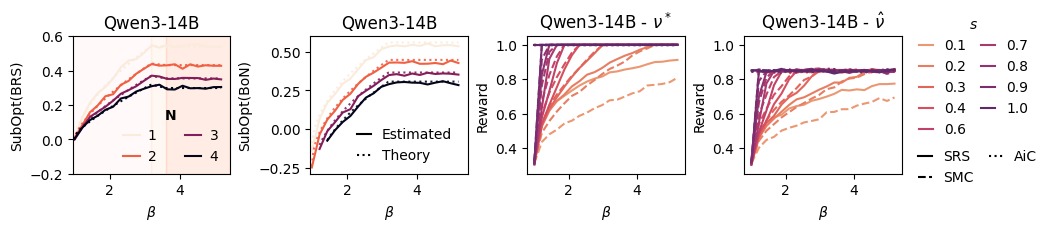

In [35]:
import matplotlib.lines as mlines

user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
#model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B"]

task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df_sequential = pd.concat(model_dfs, ignore_index=True)
# Ensure both have the same columns
if "N" not in df.columns: df["N"] = np.nan   # or a default value (e.g., 1)


model_dfs_batched = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-batched.csv"
    model_df = pd.read_csv(data_path)
    model_dfs_batched.append(model_df)

for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN.csv"
    model_df = pd.read_csv(data_path)
    model_dfs_batched.append(model_df)

for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-BoN-beta1.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df_batched = pd.concat(model_dfs_batched, ignore_index=True)


# Concatenate
df = pd.concat([df_sequential, df_batched], ignore_index=True)
df

model_ids = ["Qwen/Qwen3-14B"]
colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

Ns = df[df["model_id"]=="Qwen/Qwen3-14B"]["N"].dropna().unique()

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}

batch_size = 3

fig, axs = plt.subplots(1, 4, figsize=(9, 2.2), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip([axs[0]], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BRS")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        ax.set_title(model_id.split("/")[-1])

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn_batch_estimate(s, shat, J, batch_size)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", color=color_map[batch_size])    
        ax.set_ylim(-0.2, 0.6)
    
    
    
    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)
    ax.set_xlabel(r"$\beta$")

######################################################################################################################################################

for ax,model_id in zip([axs[1]], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BoN")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        est_n = (estimated_df[estimated_df["N"] == batch_size]
             .groupby("beta", as_index=False)["reward"].mean())   # one row per beta
        gt = (gt_df.groupby("beta", as_index=False)["reward"].mean())

        common = pd.merge(gt, est_n, on="beta", how="inner", suffixes=("_gt", "_est"))
        suboptimality = common["reward_gt"] - common["reward_est"]

        ax.plot(common["beta"], suboptimality,
                label=f"N={batch_size}", color=color_map[batch_size])
        
        ax.set_title(model_id.split("/")[-1])

        # theory curve (uses continuous betas)
        betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
        subopt_theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, batch_size)
        subopt_theory = [subopt_theory_fn(b) for b in betas]
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", alpha=0.9, color=color_map[batch_size])    
    
    max_beta = np.max(betas)
    # ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    # ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    # ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)
    ax.set_xlabel(r"$\beta$")


axs[0].set_ylabel("SubOpt(BRS)")
axs[1].set_ylabel("SubOpt(BoN)")

# One entry per N (colored solid line)
N_lines = [Line2D([0], [0], color=color_map[n]) for n in Ns]
print(Ns)
N_labels = [int(n) for n in Ns]

# One for Estimated (solid line)
est_line = Line2D([0], [0], color="black", label="Estimated")

# One for Theory (dotted line)
theory_line = Line2D([0], [0], color="black", linestyle=":", label="Theory")

# Combine
legend_elements = N_lines + [est_line, theory_line]
legend_labels = N_labels + ["Estimated", "Theory"]

# Place the legend manually (adjust bbox_to_anchor for placement)
fig.legend(
    N_lines,
    N_labels,
    title="N",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.25, 0.59),  # adjust as needed
    handlelength=1.2, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)

# Legend for line styles (solid/dotted)
est_line = Line2D([0], [0], color="black", label="Estimated")
theory_line = Line2D([0], [0], color="black", linestyle=":", label="Theory")

fig.legend(
    [est_line, theory_line],
    ["Estimated", "Theory"],
    bbox_to_anchor=(0.51, 0.5),
    ncol=1,
    frameon=False,
    handlelength=1,
    handletextpad=0.8,
    columnspacing=1.1
)

##########################################################################################################################################################
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_ablation_s/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-ablation.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)
df

# Filter data first and remove s_used == 0
filtered_df = df[(df["model_id"] == "Qwen/Qwen3-14B") & (df["s_used"] != 0)]

# Get unique s_used values (rounded to 1 decimal for labeling)
s_used_values = np.round(filtered_df["s_used"].unique(), 1)
s_used_values = np.sort(s_used_values)  # sorted for consistent color mapping

# Set color palette
palette = sns.color_palette("flare", n_colors=len(s_used_values))
colors = {s: palette[i] for i, s in enumerate(s_used_values)}

# Define line styles for each method
linestyles = {
    "SRS": "-",
    "SMC": "--",
    "AiC": ":"
}

# Get unique modes for faceting
modes = filtered_df["mode"].unique()
n_cols = len(modes)

# Create subplots

# Ensure axes is iterable
if n_cols == 1:
    axes = [axes]

# Plot for each mode
for ax, mode in zip(axs[2:], modes):
    mode_df = filtered_df[filtered_df["mode"] == mode]

    # Group by hue (s_used) and style (method)
    # for (s_used, method), group in mode_df.groupby(["s_used", "method"]):
    #     s_rounded = round(s_used, 1)
    #     group_sorted = group.sort_values("beta")
    #     ax.plot(group_sorted["beta"], group_sorted["reward"],
    #             label=f"{s_rounded}",
    #             color=colors[s_rounded],
    #             linestyle=linestyles[method])
    for (s_used, method), group in mode_df.groupby(["s_used", "method"]):
        print(s_used)
        s_rounded = round(s_used, 1)
        print(s_rounded)
        group_sorted = group.sort_values("beta")

        # Plot the curve
        ax.plot(
            group_sorted["beta"],
            group_sorted["reward"],
            label=f"{s_rounded}",
            color=colors[s_rounded],
            linestyle=linestyles[method]
        )

        # ✅ Highlight region for s_used == 0.3
        if round(s_used, 2) == 0.3:
            ax.fill_between(
                group_sorted["beta"],
                group_sorted["reward"],
                alpha=0.2,
                color=colors[s_rounded],
                label=None  # avoid duplicate legend entry
            )

    title = r"Qwen3-14B - $\nu^*$" if mode == "ground_truth" else "Qwen3-14B - $\hat{\\nu}$"
    ax.set_title(title)
    ax.set_ylim(0.25, 1.05)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Reward")

# -------------------------
# Custom Legend: Line styles (method)
# -------------------------
method_legend_lines = [
    mlines.Line2D([], [], color="black", linestyle=linestyles[m], label=m)
    for m in linestyles
]
fig.legend(
    handles=method_legend_lines, 
    title="", 
    bbox_to_anchor=(1.16, 0.4),
    ncol=2,
    frameon=False,
    handlelength=1,
    handletextpad=0.8,
    columnspacing=1.1
)

# -------------------------
# Custom Legend: Colors (s_used)
# -------------------------
s_legend_lines = [
    mlines.Line2D([], [], color=colors[s], linestyle='-', label=f"{s}")
    for s in s_used_values
]
fig.legend(
    handles=s_legend_lines, 
    title=r"$s$", 
    bbox_to_anchor=(1.15, 1),
    ncol=2,
    frameon=False,
    handlelength=1,
    handletextpad=0.8,
    columnspacing=1.1
)

# Add both legends to the first axis

#plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig2.pdf",
    dpi=800, 
    bbox_inches="tight",
    
    
)
plt.show()

In [ ]:
colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

Ns = sorted(df["N"].dropna().unique())

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}

batch_size = 3

fig, axs = plt.subplots(1, len(model_ids)*2, figsize=(9, 2.2), sharey=False, sharex=False, constrained_layout=True)

for ax,model_id in zip(axs[:2], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BRS")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        ax.set_title(model_id.split("/")[-1])

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn_batch_estimate(s, shat, J, batch_size)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", color=color_map[batch_size])    
    
    
    
    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)
    ax.set_xlabel(r"$\beta$")

######################################################################################################################################################


for ax,model_id in zip(axs[2:], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BoN")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        est_n = (estimated_df[estimated_df["N"] == batch_size]
             .groupby("beta", as_index=False)["reward"].mean())   # one row per beta
        gt = (gt_df.groupby("beta", as_index=False)["reward"].mean())

        common = pd.merge(gt, est_n, on="beta", how="inner", suffixes=("_gt", "_est"))
        suboptimality = common["reward_gt"] - common["reward_est"]

        ax.plot(common["beta"], suboptimality,
                label=f"N={batch_size}", color=color_map[batch_size])
        
        ax.set_title(model_id.split("/")[-1])

        # theory curve (uses continuous betas)
        betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
        subopt_theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, batch_size)
        subopt_theory = [subopt_theory_fn(b) for b in betas]
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", alpha=0.9, color=color_map[batch_size])    
    
    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)
    ax.set_xlabel(r"$\beta$")


axs[0].set_ylabel("SubOpt(BRS)")
axs[2].set_ylabel("SubOpt(BoN)")

# One entry per N (colored solid line)
N_lines = [Line2D([0], [0], color=color_map[n]) for n in Ns]
print(Ns)
N_labels = [int(n) for n in Ns]

# One for Estimated (solid line)
est_line = Line2D([0], [0], color="black", label="Estimated")

# One for Theory (dotted line)
theory_line = Line2D([0], [0], color="black", linestyle=":", label="Theory")

# Combine
legend_elements = N_lines + [est_line, theory_line]
legend_labels = N_labels + ["Estimated", "Theory"]

# Place the legend manually (adjust bbox_to_anchor for placement)
fig.legend(
    N_lines,
    N_labels,
    title="N",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(1.13, 1),  # adjust as needed
    handlelength=1.2, 
    handletextpad=0.6,
    title_fontproperties={'weight': 'bold'}
)

# Legend for line styles (solid/dotted)
est_line = Line2D([0], [0], color="black", label="Estimated")
theory_line = Line2D([0], [0], color="black", linestyle=":", label="Theory")

fig.legend(
    [est_line, theory_line],
    ["Estimated", "Theory"],
    bbox_to_anchor=(1.13, 0.5),
    ncol=1,
    frameon=False,
    handlelength=1,
    handletextpad=0.8,
    columnspacing=1.1
)

#plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig2.pdf",
    dpi=800, 
    bbox_inches="tight",
)
plt.show()

KeyError: 'N'

/tmp/ipykernel_2716098/3644990965.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r", len(Ns))


0.6626151305802676
0.6494691619459465


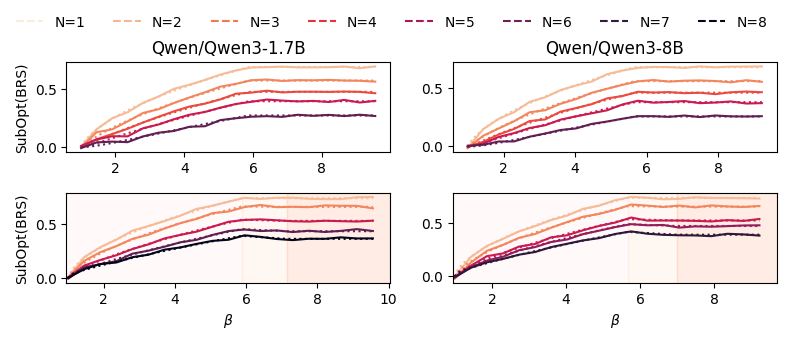

In [ ]:
def get_subopt_theory_fn_batch(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        M = min(1/s, m/s) 
        return otc(beta, s)*((1-1/M)**N)
    return subopt_theory_fn

def get_subopt_theory_fn_batch_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m_star = s + np.sqrt(s*(1-s)*(beta-1))
        m_shat = shat + np.sqrt(shat*(1-shat)*(beta-1))
        M = min(1/shat, m_shat/shat) 
        alpha = 1 - (1-1/M)**N
        OTC = otc(beta, s)
        TPR = shat + (1 - s) * J
        
        # Transport regime
        if beta <= min(1/s, 1/shat):
            term = m_star/s - ( (m_shat*TPR)/(shat) + ((1-m_shat)*(1-TPR))/(1-shat) )
            suboptimality = (1-alpha)*OTC + alpha*s*term #( m_star/s - ( (m_shat*TPR)/shat + ((1-m_shat)*(1-TPR))/(1-shat)))

        # Policy Improvement regime
        elif min(1/shat, 1/s) < beta <= max(1/shat, 1/s):
            if shat > s:
                term = m_star/s - TPR/shat
            else:
                term = 1/s - ((m_shat*TPR)/shat + (((1-m_shat)*(1-TPR))/(1-shat)) )
            suboptimality = (1-alpha)*OTC + alpha*s*term
        
        # Saturation regime
        else: #beta > max(1/shat, 1/s):
            suboptimality = (1-alpha)*OTC + alpha*s*(1/s - TPR/shat)
        
        return suboptimality
    return subopt_theory_fn


colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

Ns = sorted(df["N"].unique())

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}

batch_size = 3

fig, axs = plt.subplots(2, len(model_ids), figsize=(8, 3.2), sharey=False, sharex=False)

for ax,model_id in zip(axs[0], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="BRS")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        ax.set_title(model_id)

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn_batch(s, shat, batch_size)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

    
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", color=color_map[batch_size])    
    #ax.set_xlabel(r"$\beta$")

for ax,model_id in zip(axs[1], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BRS")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BRS")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        #ax.set_title(model_id)

        betas = gt_df["beta"].unique()
        betas = np.linspace(1, np.max(betas), 100)
        subopt_theory_fn = get_subopt_theory_fn_batch_estimate(s, shat, J, batch_size)
        subopt_theory =  [subopt_theory_fn(beta) for beta in betas]
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", color=color_map[batch_size])    
    
    
    
    max_beta = np.max(betas)
    ax.axvspan(-1, 1/s, color="mistyrose", alpha=0.2)
    ax.axvspan(1/s, 1/shat, color="peachpuff", alpha=0.2)
    ax.axvspan(1/shat, max_beta*1.05,color="lightsalmon", alpha=0.2)
    ax.set_xlim(0.95, max_beta*1.05)
    ax.set_xlabel(r"$\beta$")


# After plotting everything:
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Deduplicate
unique = dict(zip(labels, handles))

# Place a single legend on top
fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.5, 1.07),
        loc="upper center", ncol=8, frameon=False)


axs[0][0].set_ylabel("SubOpt(BRS)")
axs[1][0].set_ylabel("SubOpt(BRS)")
#axs[0][-2].legend(ncols=2)
plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig2.pdf",
    dpi=800, 
    bbox_inches="tight",
    #bbox_extra_artists=(legend1, legend2)
)
plt.show()

In [99]:
[a for a in axes.flat]

[<Axes: title={'center': 'Qwen/Qwen3-1.7B (ground_truth)'}, xlabel='$\\beta$', ylabel='Reward'>,
 <Axes: title={'center': 'Qwen/Qwen3-8B (ground_truth)'}, xlabel='$\\beta$', ylabel='Reward'>,
 <Axes: title={'center': 'Qwen/Qwen3-14B (ground_truth)'}, xlabel='$\\beta$', ylabel='Reward'>,
 <Axes: title={'center': 'Qwen/Qwen3-1.7B (estimate)'}, xlabel='$\\beta$', ylabel='Reward'>,
 <Axes: title={'center': 'Qwen/Qwen3-8B (estimate)'}, xlabel='$\\beta$', ylabel='Reward'>,
 <Axes: title={'center': 'Qwen/Qwen3-14B (estimate)'}, xlabel='$\\beta$', ylabel='Reward'>]

/tmp/ipykernel_2431071/250346621.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r", len(Ns))


0.6626151305802676
0.6494691619459465
0.685709773454669
0.6626151305802676
0.6494691619459465
0.685709773454669


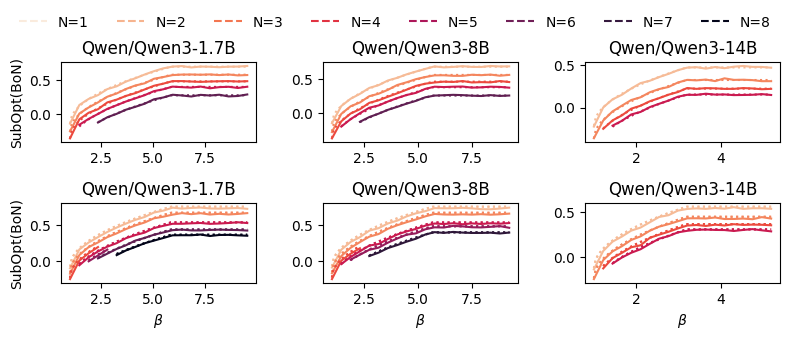

In [109]:
def get_subopt_theory_fn_BoN(s, shat, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        return (1-s)**(N+1) - max(0, 1-m)
    return subopt_theory_fn

def get_subopt_theory_fn_BoN_estimate(s, shat, J, N):
    def subopt_theory_fn(beta):
        m = s + np.sqrt(s*(1-s)*(beta-1))
        sampling_error = ((1-shat)**(N+1))*(s/shat)*J - max(0, 1-m)
        verification_error = (1-s)*(1-(s*J)/shat)
        return sampling_error + verification_error        
    return subopt_theory_fn


colors={
    "ground_truth": "tab:blue",
    "estimate": "tab:orange"
}

Ns = sorted(df["N"].unique())

# Build color map for N (rocket_r in seaborn ~ reversed rocket colormap)
cmap = plt.cm.get_cmap("rocket_r", len(Ns))
color_map = {n: cmap(i) for i, n in enumerate(Ns)}


fig, axs = plt.subplots(2, len(model_ids), figsize=(8, 3.2), sharey=False, sharex=False)

for ax,model_id in zip(axs[0], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )
    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="BoN")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        est_n = (estimated_df[estimated_df["N"] == batch_size]
             .groupby("beta", as_index=False)["reward"].mean())   # one row per beta
        gt = (gt_df.groupby("beta", as_index=False)["reward"].mean())

        common = pd.merge(gt, est_n, on="beta", how="inner", suffixes=("_gt", "_est"))
        suboptimality = common["reward_gt"] - common["reward_est"]

        ax.plot(common["beta"], suboptimality,
                label=f"N={batch_size}", color=color_map[batch_size])
        
        # theory curve (uses continuous betas)
        betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
        subopt_theory_fn = get_subopt_theory_fn_BoN(s, shat, batch_size)
        subopt_theory = [subopt_theory_fn(b) for b in betas]
        ax.plot(betas, subopt_theory, linestyle=":", color=color_map[batch_size])
        ax.set_title(model_id)


        # estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        # suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        # ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        # ax.set_title(model_id)

        # betas = gt_df["beta"].unique()
        # betas = np.linspace(1, np.max(betas), 100)
        # subopt_theory_fn = get_subopt_theory_fn_BoN(s, shat, batch_size)
        # subopt_theory =  [subopt_theory_fn(beta) for beta in betas]
        # ax.plot(betas, subopt_theory, label="theory", linestyle=":", color=color_map[batch_size])   

     

for ax,model_id in zip(axs[1], model_ids):

    # Compute s
    s = (
        df[
            (df["mode"] == "ground_truth") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute shat
    shat = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["s"].iloc[0]
    )

    # Compute J
    J = (
        df[
            (df["mode"] == "estimate") &
            (df["model_id"] == model_id) &
            (df["method"]=="BoN")
        ]["J"].iloc[0]
    )
    print(J)

    gt_df = df[
        (df["mode"] == "ground_truth") &
        (df["model_id"] == model_id) &
        (df["method"]=="SRS")
    ]

    estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == model_id) &
        (df["method"]=="BoN")
    ]

    for i,batch_size in enumerate(estimated_df["N"].unique()):

        # estimated_df_n = estimated_df[estimated_df["N"]==batch_size]
        # print(len(gt_df["reward"].values))
        # suboptimality = gt_df["reward"].values - estimated_df_n["reward"].values
        # ax.plot(gt_df["beta"], suboptimality, label=method,  color=color_map[batch_size])
        est_n = (estimated_df[estimated_df["N"] == batch_size]
             .groupby("beta", as_index=False)["reward"].mean())   # one row per beta
        gt = (gt_df.groupby("beta", as_index=False)["reward"].mean())

        common = pd.merge(gt, est_n, on="beta", how="inner", suffixes=("_gt", "_est"))
        suboptimality = common["reward_gt"] - common["reward_est"]

        ax.plot(common["beta"], suboptimality,
                label=f"N={batch_size}", color=color_map[batch_size])
        ax.set_title(model_id)

        # theory curve (uses continuous betas)
        betas = np.linspace(common["beta"].min(), common["beta"].max(), 100)
        subopt_theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, batch_size)
        subopt_theory = [subopt_theory_fn(b) for b in betas]
        ax.plot(betas, subopt_theory, linestyle=":", color=color_map[batch_size])

        # betas = gt_df["beta"].unique()
        # betas = np.linspace(1, np.max(betas), 100)
        # subopt_theory_fn = get_subopt_theory_fn_BoN_estimate(s, shat, J, batch_size)
        # subopt_theory =  [subopt_theory_fn(beta) for beta in betas]

    
        ax.plot(betas, subopt_theory, label="theory", linestyle=":", alpha=0.9, color=color_map[batch_size])    
    ax.set_xlabel(r"$\beta$")


# After plotting everything:
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Deduplicate
unique = dict(zip(labels, handles))

# Place a single legend on top
fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.5, 1.07),
        loc="upper center", ncol=8, frameon=False)


axs[0][0].set_ylabel("SubOpt(BoN)")
axs[1][0].set_ylabel("SubOpt(BoN)")
#axs[0][-2].legend(ncols=2)
plt.tight_layout()
plt.savefig(
    "/home/mb1921/ot-resampling/tasks/gsm8k/results-2/plots/exp_fig3.pdf",
    dpi=800, 
    bbox_inches="tight",
    #bbox_extra_artists=(legend1, legend2)
)
plt.show()

In [23]:
estimated_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == "Qwen/Qwen3-1.7B") &
        (df["method"]=="BoN")
    ]

estimated_df_n = estimated_df[estimated_df["N"]==batch_size].reset_index()
estimated_df_n

,index,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
0,933,1.450358,Qwen/Qwen3-1.7B,0.14003,0.4912,0.499923,5.0,0.0,BoN,estimate,0.662615,4.0
1,942,1.900716,Qwen/Qwen3-1.7B,0.14003,0.4722,0.499227,5.0,0.0,BoN,estimate,0.662615,4.0
2,952,2.351075,Qwen/Qwen3-1.7B,0.14003,0.4606,0.498445,5.0,0.0,BoN,estimate,0.662615,4.0
3,961,2.801433,Qwen/Qwen3-1.7B,0.14003,0.4734,0.499292,5.0,0.0,BoN,estimate,0.662615,4.0
4,971,3.251791,Qwen/Qwen3-1.7B,0.14003,0.4774,0.499489,5.0,0.0,BoN,estimate,0.662615,4.0
5,981,3.702149,Qwen/Qwen3-1.7B,0.14003,0.4670,0.498910,5.0,0.0,BoN,estimate,0.662615,4.0
6,991,4.152508,Qwen/Qwen3-1.7B,0.14003,0.4778,0.499507,5.0,0.0,BoN,estimate,0.662615,4.0
7,1001,4.602866,Qwen/Qwen3-1.7B,0.14003,0.4818,0.499669,5.0,0.0,BoN,estimate,0.662615,4.0
8,1011,5.053224,Qwen/Qwen3-1.7B,0.14003,0.4712,0.499170,5.0,0.0,BoN,estimate,0.662615,4.0
9,1021,5.503582,Qwen/Qwen3-1.7B,0.14003,0.4756,0.499404,5.0,0.0,BoN,estimate,0.662615,4.0


In [24]:
gt_df = df[
        (df["mode"] == "estimate") &
        (df["model_id"] == "Qwen/Qwen3-1.7B") &
        (df["method"]=="SRS")
    ]

gt_df

,beta,model_id,s,reward,reward_std,iter,iter_std,method,mode,J,N
3,1.000000,Qwen/Qwen3-1.7B,0.14003,0.1730,0.378247,1.0000,0.000000,SRS,estimate,0.662615,NaN
9,1.450358,Qwen/Qwen3-1.7B,0.14003,0.3452,0.475433,2.6724,2.160990,SRS,estimate,0.662615,NaN
15,1.900716,Qwen/Qwen3-1.7B,0.14003,0.4366,0.495964,3.3828,2.884071,SRS,estimate,0.662615,NaN
21,2.351075,Qwen/Qwen3-1.7B,0.14003,0.4924,0.499942,3.8598,3.311094,SRS,estimate,0.662615,NaN
27,2.801433,Qwen/Qwen3-1.7B,0.14003,0.5284,0.499193,4.3134,3.893120,SRS,estimate,0.662615,NaN
33,3.251791,Qwen/Qwen3-1.7B,0.14003,0.5648,0.495783,4.7296,4.136337,SRS,estimate,0.662615,NaN
39,3.702149,Qwen/Qwen3-1.7B,0.14003,0.6190,0.485633,5.1836,4.724647,SRS,estimate,0.662615,NaN
45,4.152508,Qwen/Qwen3-1.7B,0.14003,0.6398,0.480058,5.3838,4.842613,SRS,estimate,0.662615,NaN
51,4.602866,Qwen/Qwen3-1.7B,0.14003,0.6870,0.463714,5.6528,4.918765,SRS,estimate,0.662615,NaN
57,5.053224,Qwen/Qwen3-1.7B,0.14003,0.7116,0.453018,5.9876,5.399838,SRS,estimate,0.662615,NaN


## Ablation in s

In [42]:
user_id = "marcellobullo"
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
num_episodes = 5000
model_dfs = []
for model_id in model_ids: 
    model_name = model_id.replace("/", "__")
    data_path = f"/home/mb1921/ot-resampling/tasks/{task}/results-{sample_id}/suboptimality_vs_beta_ablation_s/{task}-{model_name}-episodes{num_episodes}-i{sample_id}-ablation.csv"
    model_df = pd.read_csv(data_path)
    model_dfs.append(model_df)

df = pd.concat(model_dfs, ignore_index=True)
df

,beta,model_id,s,s_used,reward,reward_std,iter,iter_std,method,mode,J
0,1.000000,Qwen/Qwen3-1.7B,0.170036,0.0,0.0000,0.000000,1.2102,0.512266,SRS,ground_truth,0.662615
1,1.000000,Qwen/Qwen3-1.7B,0.170036,0.0,0.1704,0.375984,1.9932,3.151056,SMC,ground_truth,0.662615
2,1.000000,Qwen/Qwen3-1.7B,0.170036,0.0,1.0000,0.000000,5.8398,5.189001,AiC,ground_truth,0.662615
3,1.000000,Qwen/Qwen3-1.7B,0.140030,0.0,0.0654,0.247230,1.1560,0.422923,SRS,estimate,0.662615
4,1.000000,Qwen/Qwen3-1.7B,0.140030,0.0,0.1776,0.382176,2.0018,3.622954,SMC,estimate,0.662615
...,...,...,...,...,...,...,...,...,...,...,...
3595,5.182043,Qwen/Qwen3-14B,0.313583,1.0,1.0000,0.000000,3.0974,2.477804,SMC,ground_truth,0.685710
3596,5.182043,Qwen/Qwen3-14B,0.313583,1.0,1.0000,0.000000,3.1446,2.586444,AiC,ground_truth,0.685710
3597,5.182043,Qwen/Qwen3-14B,0.276199,1.0,0.8538,0.353307,3.6832,3.190743,SRS,estimate,0.685710
3598,5.182043,Qwen/Qwen3-14B,0.276199,1.0,0.8586,0.348434,3.5956,3.002009,SMC,estimate,0.685710


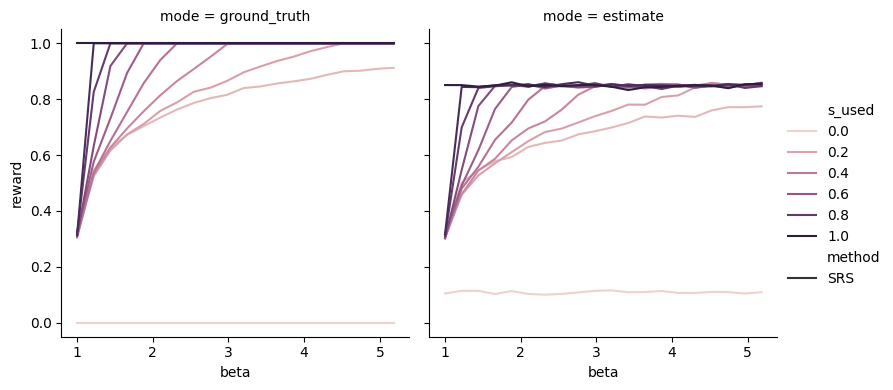

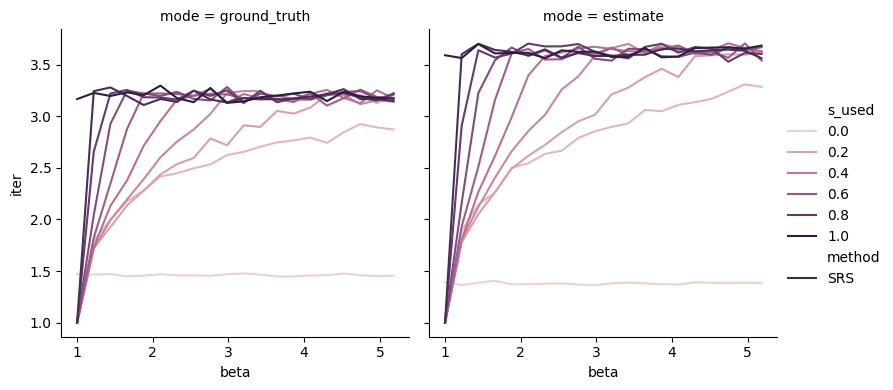

In [45]:
sns.relplot(
    data=df[(df["model_id"]=="Qwen/Qwen3-14B") & (df["method"]=="SRS")], 
    x="beta", 
    y="reward",
    hue="s_used",
    style="method",
    col="mode",
    kind="line",
    #size="s",
    height=4
)

sns.relplot(
    data=df[(df["model_id"]=="Qwen/Qwen3-14B") & (df["method"]=="SRS")], 
    x="beta", 
    y="iter",
    hue="s_used",
    style="method",
    col="mode",
    kind="line",
    #size="model_id",
    height=4
)

In [ ]:
df[(df["model_id"]=="Qwen/Qwen3-14B") & (df["method"]=="SRS") & (df["mode"]=="ground_truth")]

,beta,model_id,s,s_used,reward,reward_std,iter,iter_std,method,mode,J
2400,1.000000,Qwen/Qwen3-14B,0.313583,0.0,0.0,0.0,1.4702,0.826506,SRS,ground_truth,0.68571
2406,1.220108,Qwen/Qwen3-14B,0.313583,0.0,0.0,0.0,1.4660,0.836686,SRS,ground_truth,0.68571
2412,1.440215,Qwen/Qwen3-14B,0.313583,0.0,0.0,0.0,1.4712,0.834967,SRS,ground_truth,0.68571
2418,1.660323,Qwen/Qwen3-14B,0.313583,0.0,0.0,0.0,1.4492,0.805369,SRS,ground_truth,0.68571
2424,1.880430,Qwen/Qwen3-14B,0.313583,0.0,0.0,0.0,1.4566,0.828321,SRS,ground_truth,0.68571
...,...,...,...,...,...,...,...,...,...,...,...
3570,4.301613,Qwen/Qwen3-14B,0.313583,1.0,1.0,0.0,3.1460,2.606815,SRS,ground_truth,0.68571
3576,4.521720,Qwen/Qwen3-14B,0.313583,1.0,1.0,0.0,3.2348,2.697864,SRS,ground_truth,0.68571
3582,4.741828,Qwen/Qwen3-14B,0.313583,1.0,1.0,0.0,3.1918,2.689798,SRS,ground_truth,0.68571
3588,4.961936,Qwen/Qwen3-14B,0.313583,1.0,1.0,0.0,3.1776,2.620469,SRS,ground_truth,0.68571


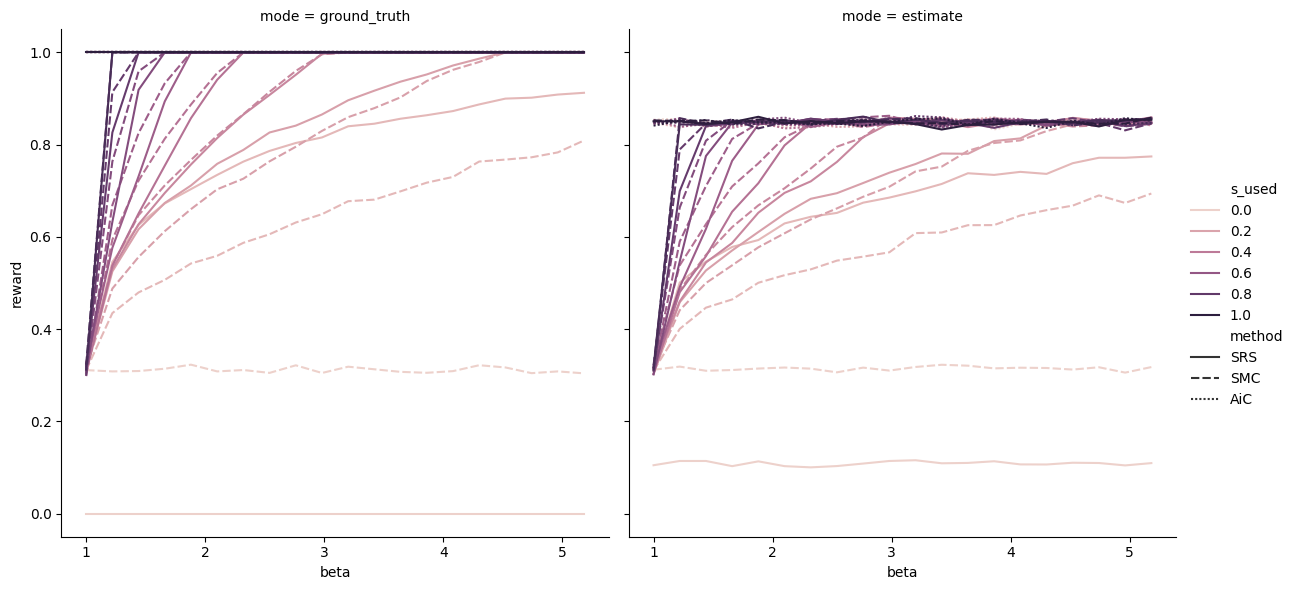

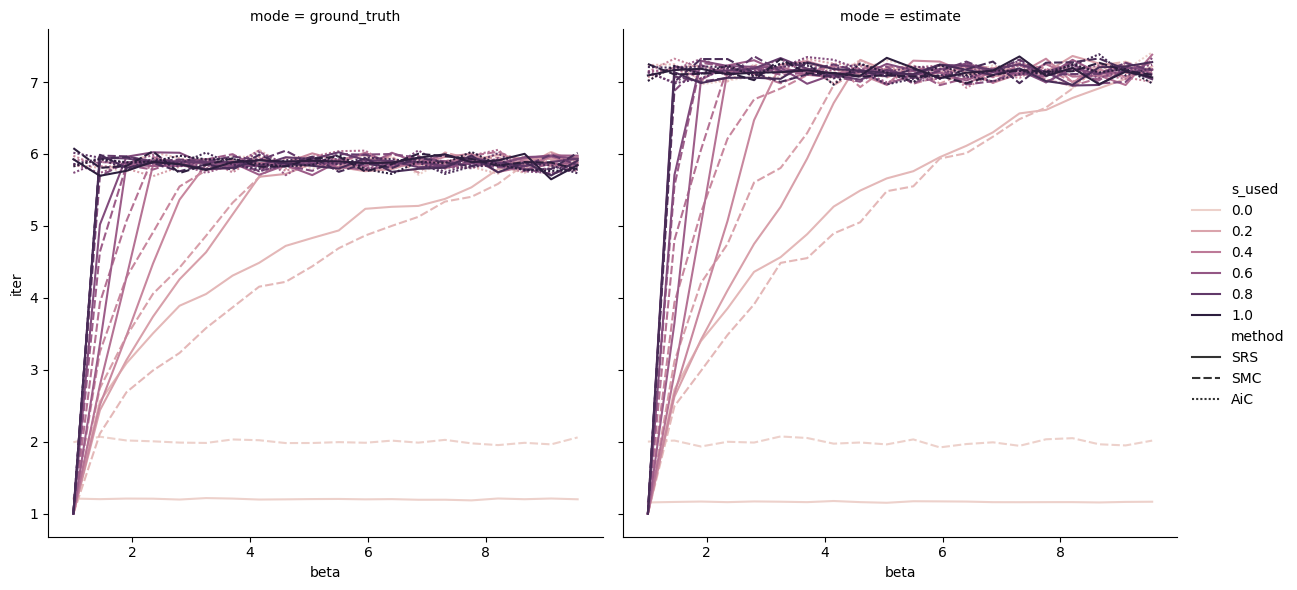

In [ ]:
sns.relplot(
    data=df[(df["model_id"]=="Qwen/Qwen3-14B")], 
    x="beta", 
    y="reward",
    hue="s_used",
    style="method",
    col="mode",
    kind="line",
    height=6
)



sns.relplot(
    data=df[df["model_id"]=="Qwen/Qwen3-1.7B"], 
    x="beta", 
    y="iter",
    hue="s_used",
    style="method",
    col="mode",
    kind="line",
    #size="model_id",
    height=6
)

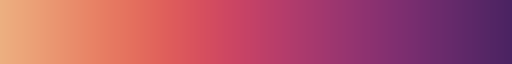

In [52]:
sns.color_palette("flare", as_cmap=True)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1. ])

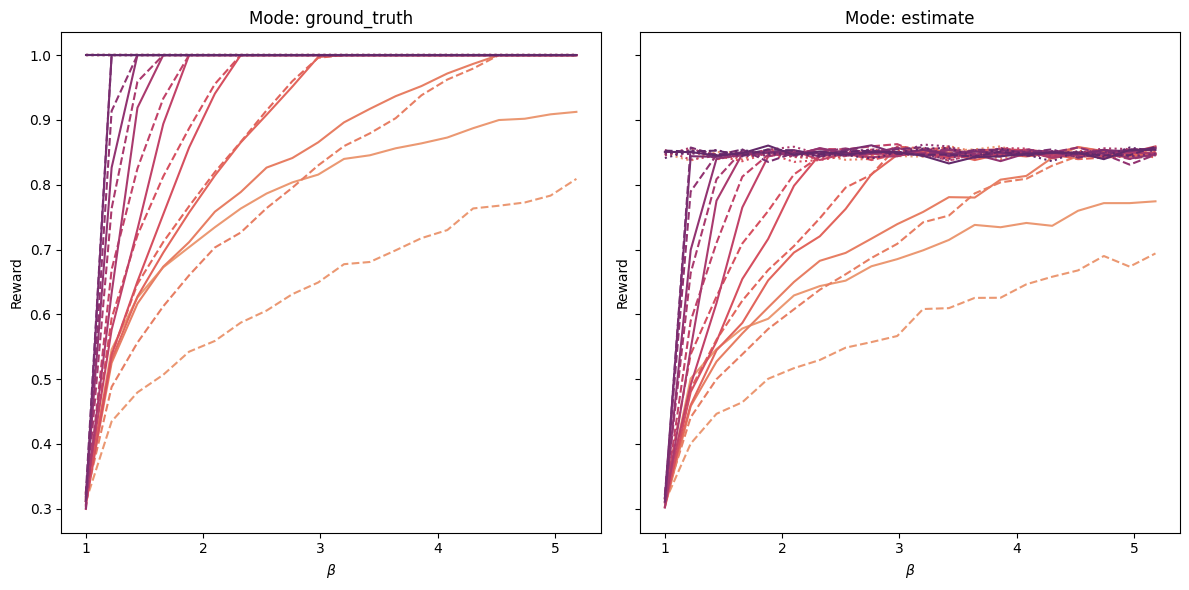

In [68]:
import matplotlib.pyplot as plt

# Filter data first
filtered_df = df[(df["model_id"] == "Qwen/Qwen3-14B") & (df["s_used"] != 0)]

s_used_values = filtered_df["s_used"].unique()
palette = sns.color_palette("flare", n_colors=len(s_used_values))

colors = {s: palette[i] for i, s in enumerate(sorted(s_used_values))}

linestyles = {
    "SRS": "-",
    "SMC": "--",
    "AiC": ":"
}


# Set it as the default color cycle in matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

# Get unique modes for faceting
modes = filtered_df["mode"].unique()
n_cols = len(modes)

# Create subplots
fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)

# Ensure axes is iterable
if n_cols == 1:
    axes = [axes]

# Plot for each mode (i.e., facet column)
for ax, mode in zip(axes, modes):
    mode_df = filtered_df[filtered_df["mode"] == mode]

    # Group by hue (s_used) and style (method)
    for (s_used, method), group in mode_df.groupby(["s_used", "method"]):
        group_sorted = group.sort_values("beta")
        ax.plot(group_sorted["beta"], group_sorted["reward"],
                label=f"{round(s_used, 1)}", color=colors[s_used], linestyle=linestyles[method])

    ax.set_title(f"Mode: {mode}")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Reward")
    #ax.legend()

plt.tight_layout()
plt.show()

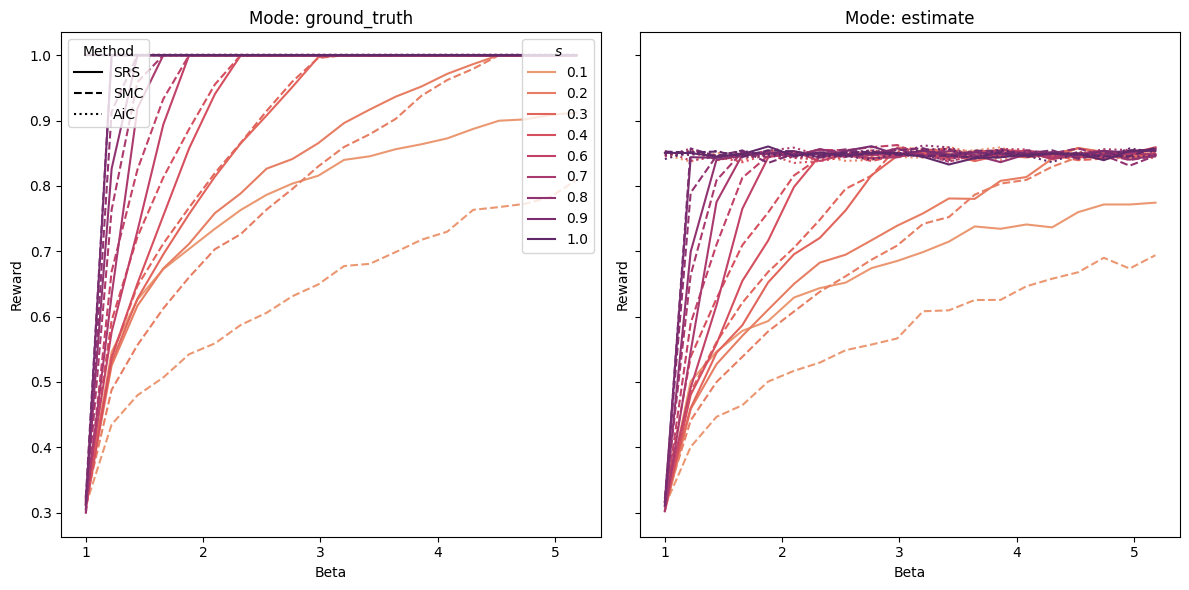

In [69]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np

# Filter data first and remove s_used == 0
filtered_df = df[(df["model_id"] == "Qwen/Qwen3-14B") & (df["s_used"] != 0)]

# Get unique s_used values (rounded to 1 decimal for labeling)
s_used_values = np.round(filtered_df["s_used"].unique(), 1)
s_used_values = np.sort(s_used_values)  # sorted for consistent color mapping

# Set color palette
palette = sns.color_palette("flare", n_colors=len(s_used_values))
colors = {s: palette[i] for i, s in enumerate(s_used_values)}

# Define line styles for each method
linestyles = {
    "SRS": "-",
    "SMC": "--",
    "AiC": ":"
}

# Get unique modes for faceting
modes = filtered_df["mode"].unique()
n_cols = len(modes)

# Create subplots
fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)

# Ensure axes is iterable
if n_cols == 1:
    axes = [axes]

# Plot for each mode
for ax, mode in zip(axes, modes):
    mode_df = filtered_df[filtered_df["mode"] == mode]

    # Group by hue (s_used) and style (method)
    for (s_used, method), group in mode_df.groupby(["s_used", "method"]):
        s_rounded = round(s_used, 1)
        group_sorted = group.sort_values("beta")
        ax.plot(group_sorted["beta"], group_sorted["reward"],
                label=f"{s_rounded}",
                color=colors[s_rounded],
                linestyle=linestyles[method])

    ax.set_title(f"Mode: {mode}")
    ax.set_xlabel("Beta")
    ax.set_ylabel("Reward")

# -------------------------
# Custom Legend: Line styles (method)
# -------------------------
method_legend_lines = [
    mlines.Line2D([], [], color="black", linestyle=linestyles[m], label=m)
    for m in linestyles
]
legend1 = axes[0].legend(handles=method_legend_lines, title="Method", loc="upper left")

# -------------------------
# Custom Legend: Colors (s_used)
# -------------------------
s_legend_lines = [
    mlines.Line2D([], [], color=colors[s], linestyle='-', label=f"{s}")
    for s in s_used_values
]
legend2 = axes[0].legend(handles=s_legend_lines, title=r"$s$", loc="upper right")

# Add both legends to the first axis
axes[0].add_artist(legend1)

plt.tight_layout()
plt.show()

In [138]:
s = 0.9 
beta = 10
m_star = min(1, s + np.sqrt(max(0, s*(1 - s)*(beta - 1))))
p = m_star / s
q = max(0, (1 - m_star) / (1 - s))
M = max(p, q)
p, q, M

(1.1111111111111112, 0, 1.1111111111111112)

/tmp/ipykernel_2716098/1018267123.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return ((1-s)*s_star)/s + (s*(1-s_star))/(1-s)


(0.6, 5.0)

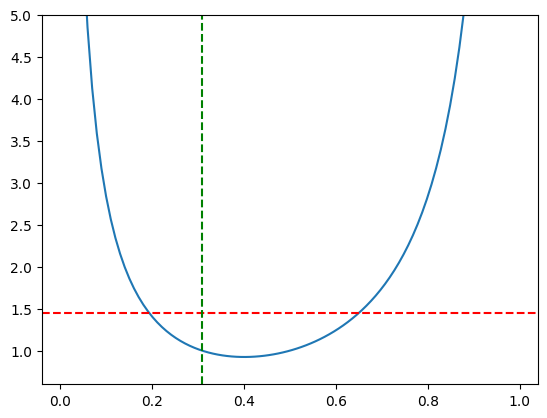

In [179]:
def compute_chi_square(s_star, s):
    return ((1-s)*s_star)/s + (s*(1-s_star))/(1-s)

s_star = 0.31
s_list = np.linspace(0, 1, 100)
beta = 1/s_star
chi_squares = [compute_chi_square(s_star, s) for s in s_list]

plt.plot(s_list, chi_squares)
plt.axhline(y=beta/(beta-1), color='r', linestyle='--')
plt.axvline(x=s_star, color='g', linestyle='--')
plt.ylim(0.6,5)

In [ ]:
def compute_chi_square(beta, s):
    m_star = min(1, s + np.sqrt(max(0, s*(1 - s)*(beta - 1))))
    p = m_star / s
    q = max(0, (1 - m_star) / (1 - s))
    M = max(p, q)
    chi_square = M - 1
    return chi_square

SyntaxError: incomplete input (986798303.py, line 1)

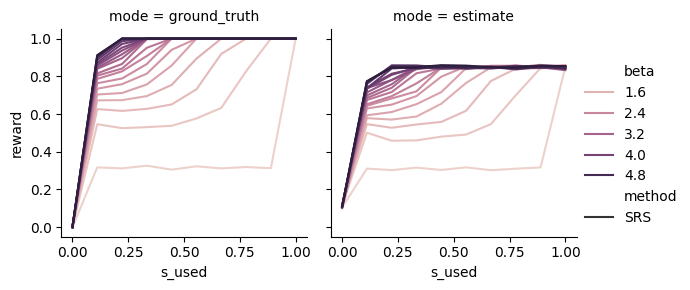

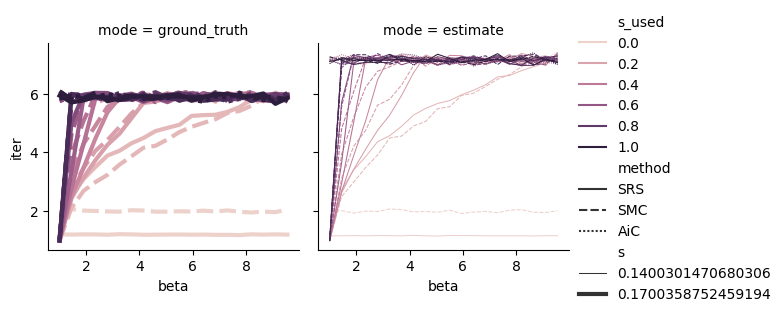

In [44]:
sns.relplot(
    data=df[(df["model_id"]=="Qwen/Qwen3-14B") & (df["method"]=="SRS")], 
    x="s_used", 
    y="reward",
    hue="beta",
    style="method",
    col="mode",
    kind="line",
    #size="s",
    height=3
)

sns.relplot(
    data=df[df["model_id"]=="Qwen/Qwen3-1.7B"], 
    x="beta", 
    y="iter",
    hue="s_used",
    style="method",
    col="mode",
    kind="line",
    size="s",
    height=3
)

In [ ]:
d# goupyby s  and for each s I want to plot suboptimality verus

NameError: name 'd' is not defined

## Threshold Imperfect verifier

In [28]:
import sys, os
ROOT = os.path.abspath("/home/mb1921/ot-resampling/")
sys.path.insert(0, ROOT)

import argparse
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from sampling_utils import get_df, get_estimated_df, get_youden_bounds, compute_s, get_membership_fn, batched_rejection_sampling

def parse_args():
    parser = argparse.ArgumentParser(description="Train Pluralistic Reward Model with configurable parameters.")
    parser.add_argument("--user_id", type=str, required=True)
    parser.add_argument("--models", type=str, nargs="+", required=True, help="List of model names to show")
    parser.add_argument("--task", type=str, required=True)
    parser.add_argument("--i", type=int, required=True)
    parser.add_argument("--seed", type=int, required=True)
    parser.add_argument("--num_beta_points", type=int, default=20)
    parser.add_argument("--num_episodes", type=int, default=1e2)
    return parser.parse_args()

def compute_shat_heuristic(s, fraction):
    return fraction*s

def compute_J_heuristic(s_list, shat_list, fraction):
    upJs = []
    for s, shat in zip(s_list, shat_list):
        _, upJ = get_youden_bounds(s, shat)
        upJs.append(upJ)  
    J = min(upJs)
    return fraction*J

def get_compute_reward(true_df):
    check_true_memebership = get_membership_fn(true_df, "exact_match")
    def compute_reward(sample_id):
        return check_true_memebership(sample_id).astype(int)
    return compute_reward

def normalize_column(df, col, a=0, b=1):
    xmin, xmax = df[col].min(), df[col].max()
    if xmax == xmin:
        # avoid divide-by-zero: fill with midpoint (a+b)/2 or just 'a'
        df[col + "_norm"] = (a + b) / 2
    else:
        df[col + "_norm"] = a + (df[col] - xmin) * (b - a) / (xmax - xmin)
    return df

def compute_tpr_fpr(df, gt_col, pred_col):
    # Booleans
    tp = ((df[gt_col] == 1) & (df[pred_col] == 1)).sum()
    tn = ((df[gt_col] == 0) & (df[pred_col] == 0)).sum()
    fp = ((df[gt_col] == 0) & (df[pred_col] == 1)).sum()
    fn = ((df[gt_col] == 1) & (df[pred_col] == 0)).sum()

    # Rates
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0   # True Positive Rate
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0   # True Negative Rate

    return tpr, fpr


#### Qwen/Qwen3-1.7B ####
fpr:0.26260257913247365, tpr:0.9345088161209067, th:0.5858585858585859

#### Qwen/Qwen3-1.7B ####
fpr:0.246189917936694, tpr:0.9193954659949622, th:0.595959595959596

#### Qwen/Qwen3-1.7B ####
fpr:0.22919109026963658, tpr:0.9030226700251889, th:0.6060606060606061

#### Qwen/Qwen3-1.7B ####
fpr:0.20808909730363423, tpr:0.8866498740554156, th:0.6161616161616162

#### Qwen/Qwen3-1.7B ####
fpr:0.19343493552168817, tpr:0.8664987405541562, th:0.6262626262626263

#### Qwen/Qwen3-1.7B ####
fpr:0.1746776084407972, tpr:0.845088161209068, th:0.6363636363636365

#### Qwen/Qwen3-1.7B ####
fpr:0.14947245017584995, tpr:0.8022670025188917, th:0.6464646464646465

#### Qwen/Qwen3-1.7B ####
fpr:0.12250879249706917, tpr:0.7783375314861462, th:0.6565656565656566

#### Qwen/Qwen3-1.7B ####
fpr:0.10082063305978899, tpr:0.7279596977329975, th:0.6666666666666667

#### Qwen/Qwen3-8B ####
fpr:0.2565256525652565, tpr:0.6673866090712743, th:0.696969696969697

#### Qwen/Qwen3-8B ####
fpr:

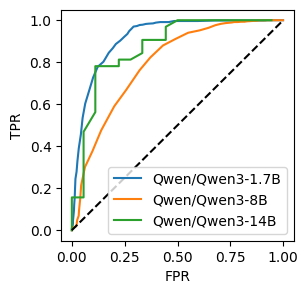

In [31]:
# Arguments
user_id = "marcellobullo"
#model_ids = [ "google/gemma-3-4b-it", "google/gemma-3-1b-it" ]
#model_ids = ["meta-llama/Llama-3.1-8B-Instruct", "meta-llama/Llama-3.2-1B-Instruct" ]
model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
task = "gsm8k"
sample_id = 2
seed = 14
batch_sizes=np.linspace(1,10,10, dtype=int)
num_beta_points = 20
num_episodes = 200
model_dfs = []

fraction = 0.8

thresholds = np.linspace(0,1, 100)
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(3,3))

for i,model_id in enumerate(model_ids):
    
    # Get the full dataset
    df = get_df(user_id, task, model_id.replace("/", "__"), sample_id)
    df = normalize_column(df, "skywork_score", 0, 1)
    df = df.rename(columns={"exact_match": "ground_truth"})

    tprs, fprs = [], []
    for th in thresholds:

        
        df["exact_match"] = (df["skywork_score_norm"] > th).astype(int)
        tpr, fpr = compute_tpr_fpr(df, "ground_truth", "exact_match")
        if 0.1<=fpr<=0.27:
            print(f"\n#### {model_id} ####")
            print(f"fpr:{fpr}, tpr:{tpr}, th:{th}")

        tprs.append(tpr)
        fprs.append(fpr)

    plt.plot(fprs, tprs, color=colors[i], label=model_id)

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color="black", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()
plt.show()





In [ ]:
if __name__ == "__main__":

    # Arguments
    user_id = "marcellobullo"
    #model_ids = [ "google/gemma-3-4b-it", "google/gemma-3-1b-it" ]
    #model_ids = ["meta-llama/Llama-3.1-8B-Instruct", "meta-llama/Llama-3.2-1B-Instruct" ]
    model_ids = ["Qwen/Qwen3-1.7B", "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]
    task = "gsm8k"
    sample_id = 2
    seed = 14
    batch_sizes=np.linspace(1,10,10, dtype=int)
    num_beta_points = 20
    num_episodes = 200
    model_dfs = []
    use_threshold = True

    fraction = 0.8
    threshold = 0.61

    # Compute a J feasible for all the models
    s_list, shat_list, true_dfs = [], [], []
    for model_id in model_ids:
        
        # Get the full dataset
        true_df = get_df(user_id, task, model_id.replace("/", "__"), sample_id)

        if threshold is not None:
            true_df = normalize_column(true_df, "skywork_score", 0, 1)
            true_df = true_df.rename(columns={"exact_match": "ground_truth"})
            true_df["exact_match"] = (true_df["skywork_score_norm"] > threshold).astype(int)

        true_dfs.append(true_df)

        # Compute s and shat
        s = compute_s(true_df, "exact_match")
        print("- s:", s)
        s_list.append(s)

        shat = compute_shat_heuristic(s, fraction)
        shat_list.append(shat)
    J = compute_J_heuristic(s_list, shat_list, fraction)

    # Compute shared betas
    mins = min(s_list)
    minshat = min(shat_list)
    betas = np.linspace(1.0, max(1/minshat, 1/mins)*1.3, num_beta_points)

    # Paramters
    rng = np.random.default_rng(seed)
    result_list = []

- s: 0.17003587524591945
- s: 0.17638821340388824
- s: 0.3135828813998671


In [ ]:
df["exact_match"] = (df["skywork_score_norm"] > 0.5).astype(int)


In [378]:
df

,target,ground_truth,prompt,chat_prompt,responses,filtered_responses,loglikelihoods,skywork_score,skywork_score_norm,exact_match
0,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"The house increased in value by 150%, which me...","120,000",-15.5625,-2.875000,0.599222,0
1,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"The house value increased by 150%, which means...",40000,-18.125,-3.765625,0.571498,0
2,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"The house increased in value by 150%, which me...",[invalid],-34.0,-6.031250,0.500973,0
3,The cost of the house and repairs came out to ...,1,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"Answer: Josh bought a house for $80,000. The v...","70,000",-22.25,-0.339844,0.678137,0
4,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"Josh’s initial cost was $80,000.\nThe value of...","12,000",-24.625,-5.375000,0.521401,0
...,...,...,...,...,...,...,...,...,...,...
9995,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"Josh’s initial investment was $80,000. He spen...",120000,-21.375,0.246094,0.696376,0
9996,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"The house increased in value by 150%, which me...",120000,-20.375,0.523438,0.705010,0
9997,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"First, calculate the increase in value: $80,00...","50,000",-13.9375,-10.000000,0.377432,0
9998,The cost of the house and repairs came out to ...,0,Josh decides to try flipping a house. He buys...,<bos><start_of_turn>user\nYou are a helpful as...,"First, calculate the increase in value: $80,00...","115,000",-14.25,1.515625,0.735895,0


In [351]:
df = true_dfs[0]
threshold = 0.5
df["skywork_score"]>threshold

0        True
1        True
2        True
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: skywork_score, Length: 10000, dtype: bool